# Object Detection in X-ray Images: Interview Task

Welcome to this technical interview task focusing on object detection in X-ray images. This notebook is designed to assess your skills in data analysis, model development, and result interpretation in the context of baggage X-ray imaging. The task should take around 3 hours.

## Background

You are interested in evaluating the quality of synthetic X-ray images for baggage screening. You wanted to use Fréchet Inception Distance(FID) to measure the difference between real data and synthetic data. However, you realise that the feature extractor used to calculate is inception-v3, a classifier model trained on solely natural images. You are worried that the domain difference between X-ray data and natural images will cause the results to be unreliable. Therefore, you have decided to **train an object detector on X-ray data and replace inception-v3 with the backbone of the object detector you trained, for Fréchet distance calculation**.  

## Task Description

You will be working with a dataset of X-ray images and tasked with developing an object detection model using Faster R-CNN with a ResNet-18 backbone and then using the backbone for calculating Fréchet distance. You are highly recommended to use PyTorch, but you can use other frameworks if you prefer. With Google Colab you can connect to a free T4, which would be sufficient for the model training here. The interview consists of 5 main questions with a total of 100 marks, each focusing on a different aspect of the machine learning pipeline:

1. Data Analysis: Explore and analyze the provided X-ray image dataset.
2. Data Preparation: Preprocess and prepare the data for model training.
3. Model Building and Fine-tuning: Implement and train the Faster R-CNN model.
4. Result Analysis: Evaluate the model's performance and interpret the results.
5. FID Calculation: Calculate the Fréchet distance to assess image quality with the backbone you have trained, similar to how Fréchet inception distance(FID) is calculated.

Please complete each section to the best of your ability. Feel free to add explanations, visualizations, or additional analyses as you see fit. Good luck!

*Note: If you are using Google Colab free T4 I suggest you start with a CPU to do data processing and preparation. Save the processed data on your Google Drive. Only connect to T4 after you reach Question 3 and mount the saved data to the T4 machine. This is because Google has a short time limit for the T4 runtime.*

## Question 1: Data Analysis (20 Marks, Suggested timing: 30 mins)

The dataset we are using is [DvXray](https://github.com/Mbwslib/DvXray?tab=readme-ov-file), please download the **positive** samples they provided on the github page and do the following tasks:

1. Keep images with indexes less than 500 and delete the rest. You should be left with 500 pairs of X-ray images and their corresponding json labels.
2. Analyze the distribution of object classes.
3. Visualize sample images with their annotations

Class Distribution:
Battery: 254
Knife: 140
Gun: 20
Fireworks: 83
Pressure_vessel: 1
Wrench: 1
Pliers: 1


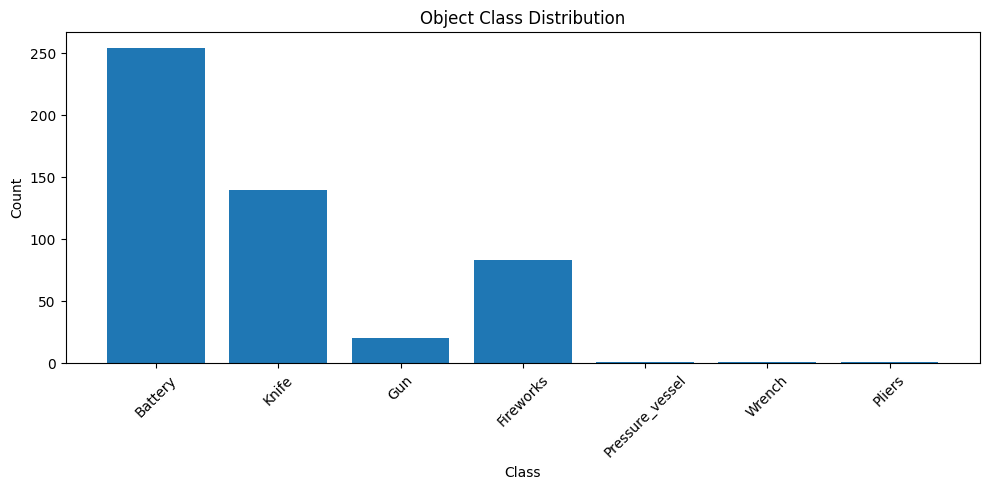

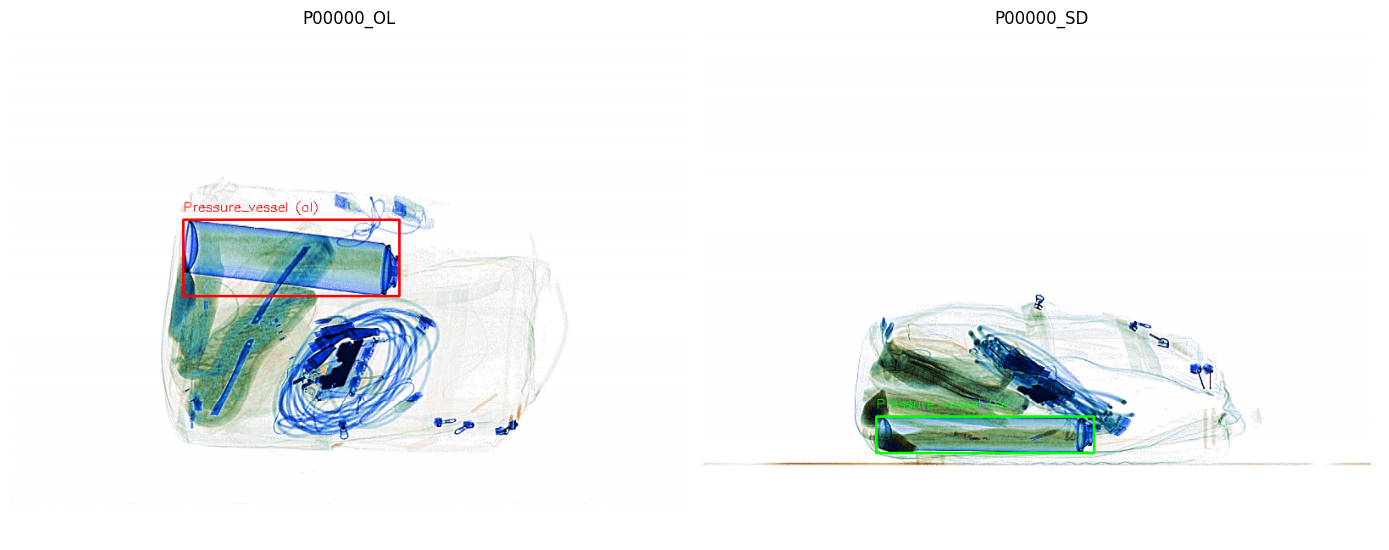

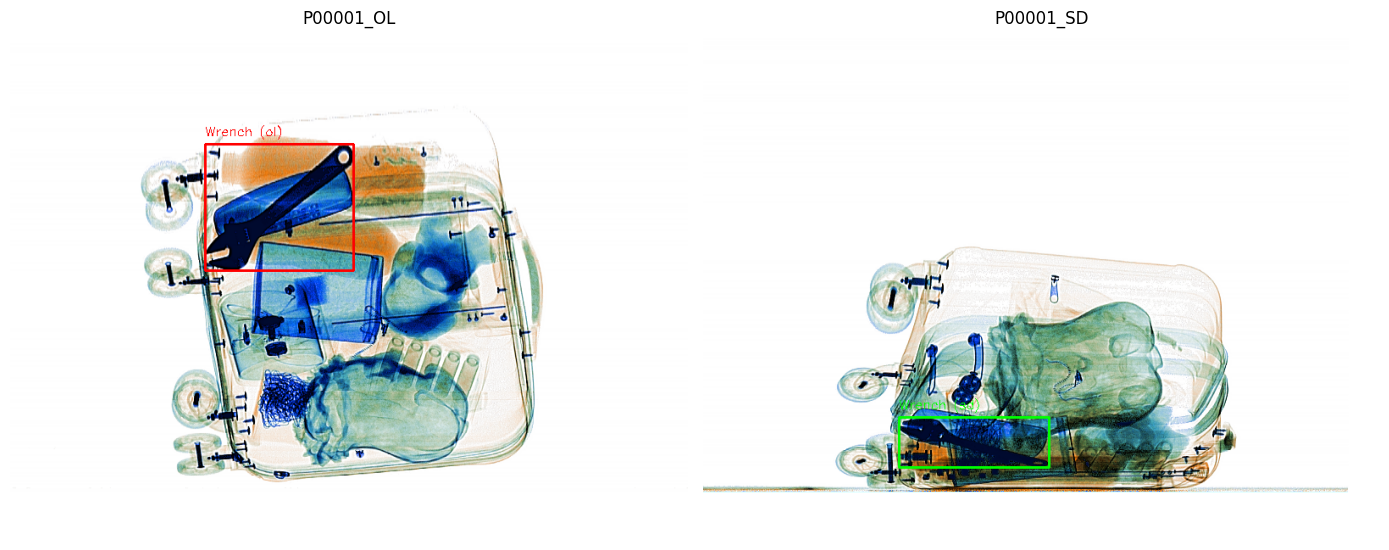

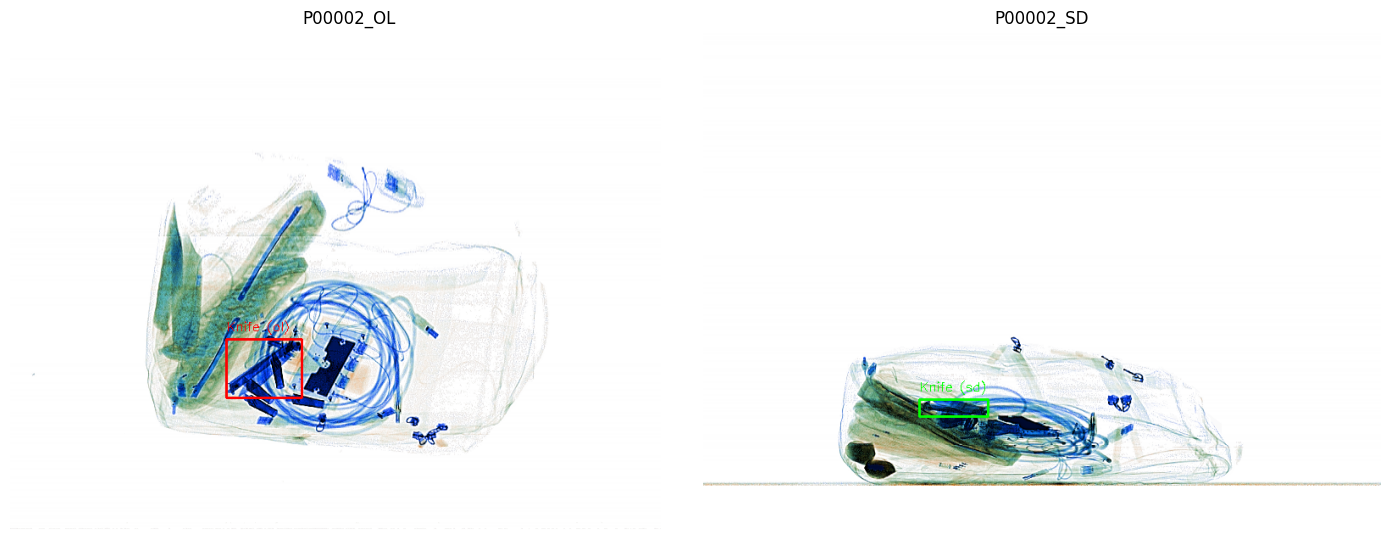

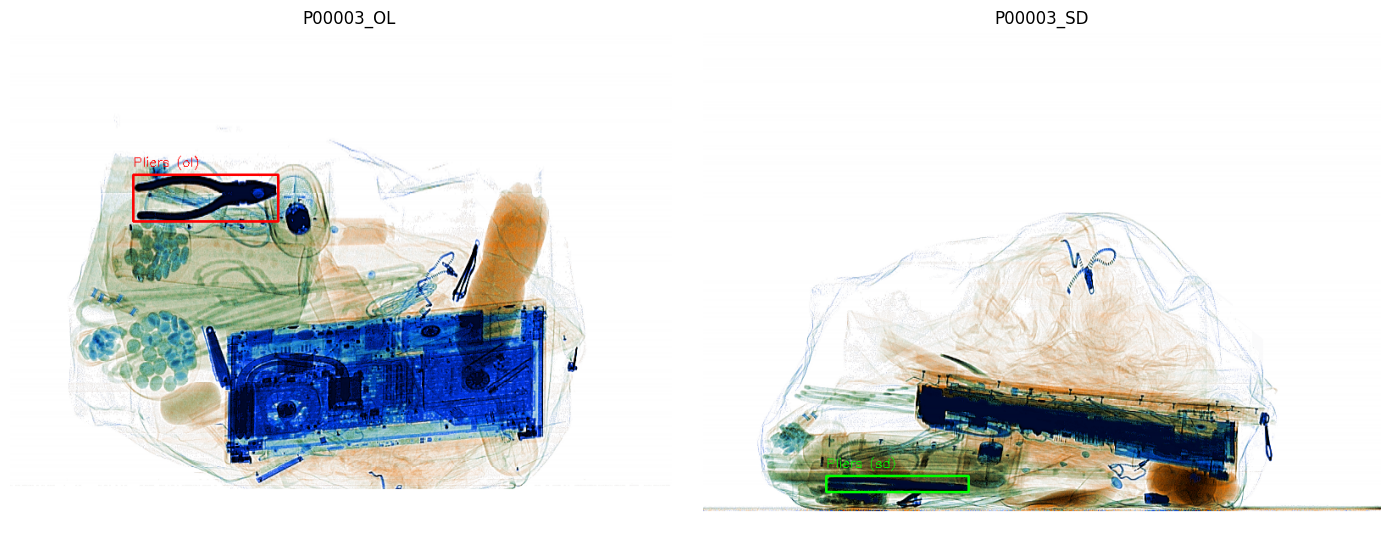

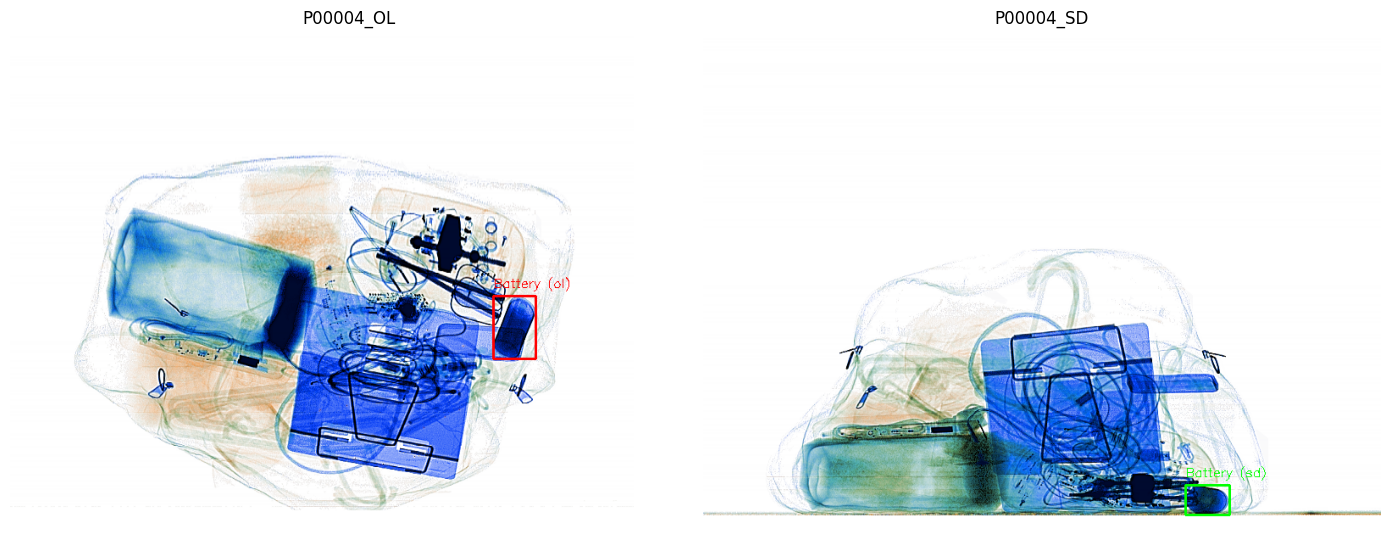

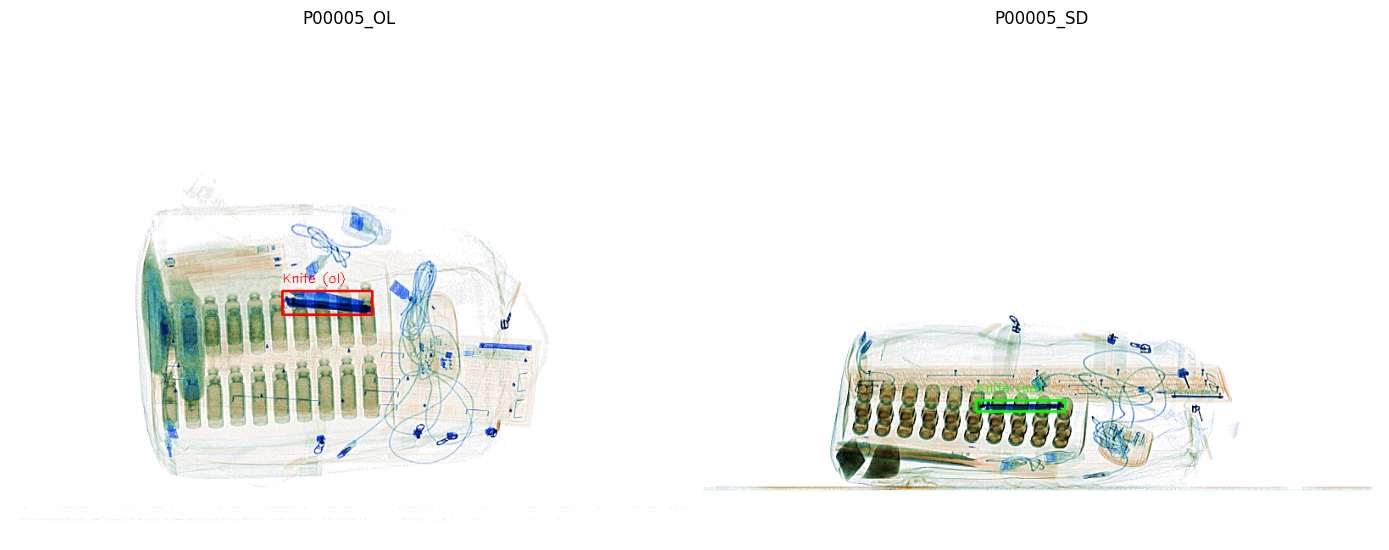

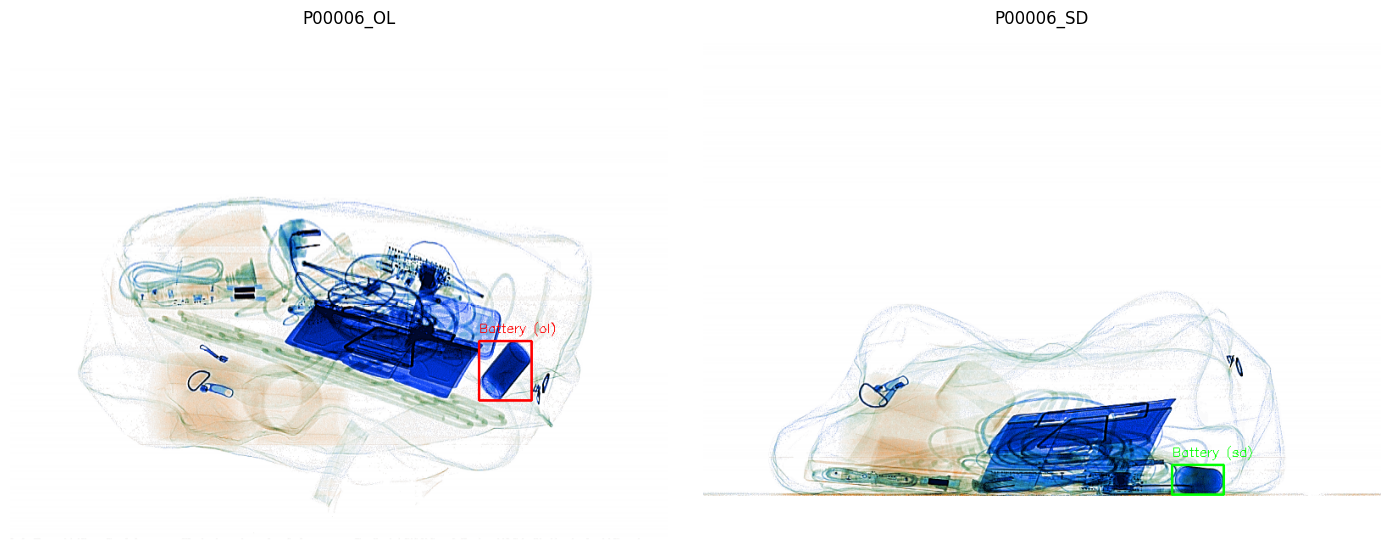

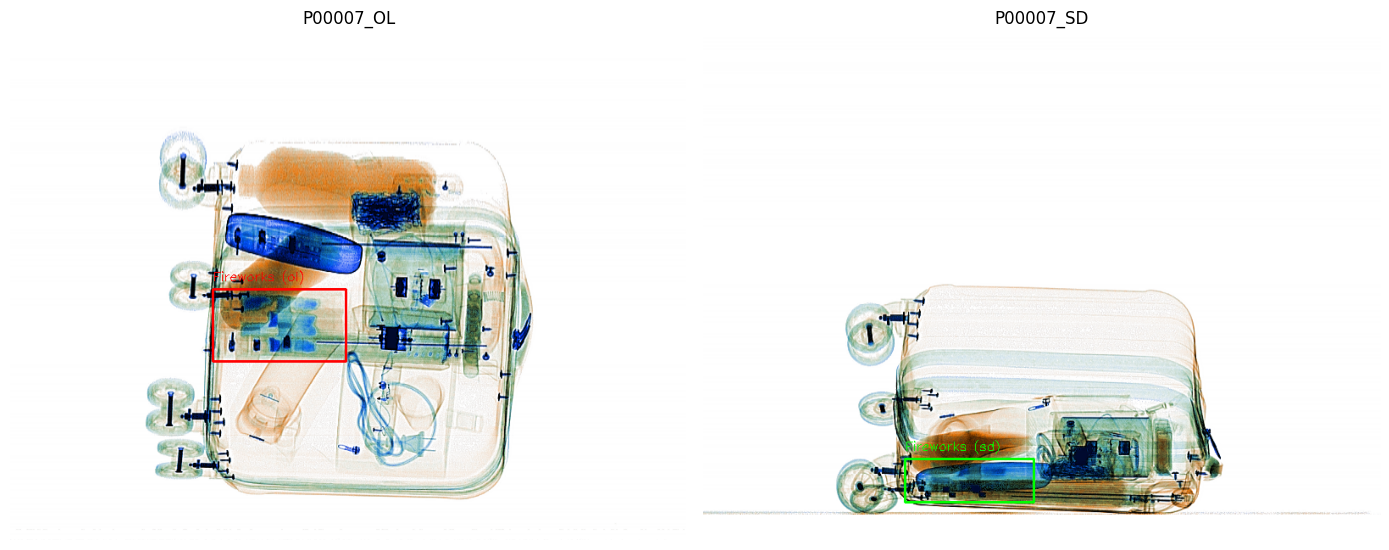

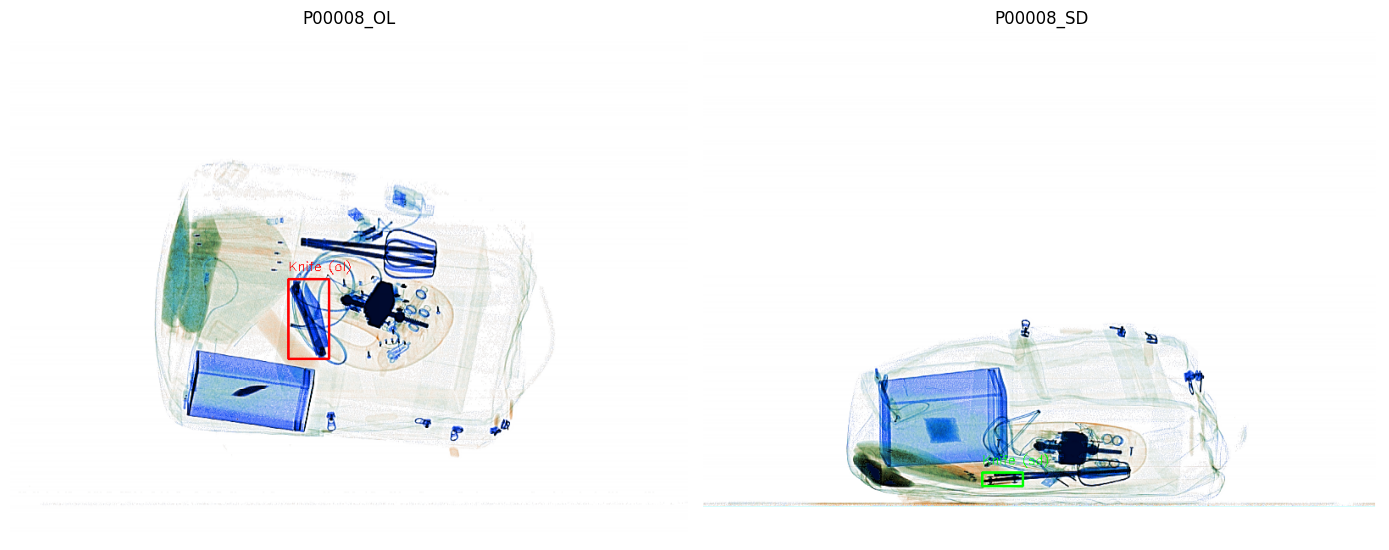

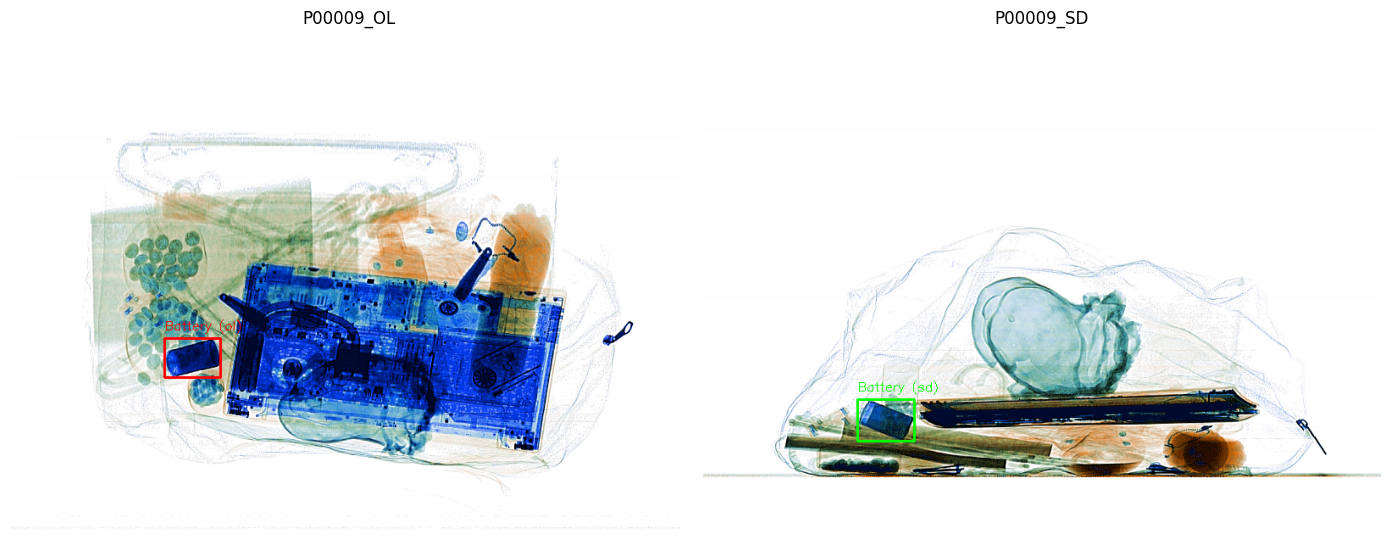

In [3]:
import os
import re
import json
import cv2
from collections import Counter
import matplotlib.pyplot as plt

# Paths to image and label directories
image_dir = 'dataset/DvXray_Positive_Samples'
label_dir = 'dataset/DvXray_Positive_Samples'
image_ext = '.png'
num_images_to_display = 10

# Regex to extract index from filename
def extract_index(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else None

# Function to process files in directory
def process_directory(directory, threshold=500):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        index = extract_index(filename)
        if index is None or index >= threshold:
            print(f"Deleting {file_path}")
            os.remove(file_path)

# Process both images and labels
process_directory(image_dir, threshold=500)
process_directory(label_dir, threshold=500)

# Counter to hold class distribution
class_counts = Counter()

# Iterate through all JSON files in the directory
for filename in os.listdir(label_dir):
    if filename.endswith('.json'):
        file_path = os.path.join(label_dir, filename)
        with open(file_path, 'r') as f:
            data = json.load(f)

            if "objects" in data:
                for obj in data["objects"]:
                    class_name = obj.get("label")
                    if class_name:
                        class_counts[class_name] += 1

# Print class distribution
print("Class Distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# Plot distribution of classes
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Object Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Visualize sample images with annotations
# List JSON annotation files
json_files = [f for f in os.listdir(label_dir) if f.endswith('json')]
json_files = sorted(json_files)[:num_images_to_display]

# Loop through annotations
for json_file in json_files:
    json_path = os.path.join(label_dir, json_file)

    with open(json_path, 'r') as f:
        annotation = json.load(f)

    base_name = annotation['name']
    img_ol_path = os.path.join(image_dir, f"{base_name}_OL{image_ext}")
    img_sd_path = os.path.join(image_dir, f"{base_name}_SD{image_ext}")

    # Load images
    img_ol = cv2.imread(img_ol_path)
    img_sd = cv2.imread(img_sd_path)

    if img_ol is None or img_sd is None:
        print(f"Could not read image:{img_ol_path}or{img_sd_path}")
        continue

    img_ol = cv2.cvtColor(img_ol, cv2.COLOR_BGR2RGB)
    img_sd = cv2.cvtColor(img_sd, cv2.COLOR_BGR2RGB)

    for obj in annotation['objects']:
        label = obj['label']

        # Draw OL bounding box
        if 'ol_bb' in obj:
            x1, y1, x2, y2 = obj['ol_bb']
            cv2.rectangle(img_ol, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img_ol, f"{label} (ol)", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # Draw SD bounding box
        if 'sd_bb' in obj:
            x1, y1, x2, y2 = obj['sd_bb']
            cv2.rectangle(img_sd, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_sd, f"{label} (sd)", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            
        # Show both images side-by-side
        fig, axs = plt.subplots(1, 2, figsize=(14, 7))
        axs[0].imshow(img_ol)
        axs[0].set_title(f"{base_name}_OL")
        axs[0].axis('off')

        axs[1].imshow(img_sd)
        axs[1].set_title(f"{base_name}_SD")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()



## Question 2 Data Preparation (20 Marks, Suggested timing: 30 mins)

Your task is to train a faster-rcnn model with the given data. Prepare the data for model training by implementing the following code. Remember to split the data into train/val/test.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import json
import os
import glob
from typing import Optional, Dict, List, Tuple, Callable, Any


class XrayDataset(Dataset):
    """Custom dataset for X-ray images with bounding box annotations."""

    def __init__(self, 
                 image_dir: str, 
                 annotation_dir: str, 
                 image_type: str="OL",   # "OL" or "SD"  
                 transform: Optional[Callable]=None, 
                 target_transform: Optional[Callable]=None,
                 debug: bool = False,
                 min_box_area: float = 1.0):
        """
        Initialize X-ray dataset for Faster R-CNN with custom annotation format
        
        Args:
            image_dir (str): Directory containing images
            annotation_dir (str): Directory containing annotation JSON files
            image_type(str): Type of image to use - "OL" or "SD"
            transform (callable, optional): Transform to apply to images
            target_transform (callable, optional): Transform to apply to targets
            debug: Enable debug prints if true

        """
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_type = image_type.upper()
        self.transform = transform
        self.target_transform = target_transform
        self.debug = debug
        self.min_box_area = min_box_area

        # Initialize data structures
        self.data_pairs: List[Dict] = []
        self.label_to_id: Dict[str, int] = {}
        self.id_to_label: Dict[int, str] = {}
        
        # Load and validate data
        self._load_data()

        if self.debug:
            self.print_dataset_stats()

    def _load_data(self) -> None:
        """Load and validate all data pairs and create label mappings."""
        self.data_pairs = self._load_data_pairs()
        self._create_label_mappings()

        # Filter out samples with no valid boxes
        self._filter_valid_samples()

    def _filter_valid_samples(self) -> None:
        """Check if this sample has valid boxes"""
        valid_pairs = []

        for pair in self.data_pairs:
            # Check if this sample has valid boxes
            try:
                # Load image to get dimensions
                image = Image.open(pair['image_path']).convert('RGB')

                # Create temporary target to check for valid boxes
                temp_target = self._create_target(pair['annotation'], 0, image.size)

                # Only keep samples with valid boxes
                if temp_target["boxes"].shape[0] > 0:
                    valid_pairs.append(pair)
                elif self.debug:
                    print(f"Filtering out sample with no valid boxes: {pair['image_name']}")

            except Exception as e:
                if self.debug:
                    print(f"Error validating sample {pair['image_name']}: {e}")
                continue

        if self.debug:
            print(f"Filtered dataset: {len(valid_pairs)}/{len(self.data_pairs)} samples have valid boxes")

        self.data_pairs = valid_pairs

    def _load_data_pairs(self) -> List[Dict]:
        """ Load and match image-annotation pairs """
        data_pairs = []
        annotation_files = glob.glob(os.path.join(self.annotation_dir, "*.json"))

        if self.debug:
            print(f"Found {len(annotation_files)} annotation files")

        for ann_file in annotation_files:
            try:
                annotation = self._load_annotation(ann_file)
                if not annotation:
                    if self.debug:
                        print(f"Skipping {ann_file}: No valid annotation")
                    continue

                image_name = self._extract_image_name(annotation, ann_file)
                image_path = self._find_image_file(image_name)

                if not image_path:
                    if self.debug:
                        print(f"Warning: Image for {image_name} not found, skipping...")
                    continue 
            
                data_pairs.append({
                    'image_path': image_path,
                    'annotation': annotation,
                    'image_name': image_name
                })

                if self.debug:
                    print(f"Loaded: {image_name}")
                    
            except Exception as e:
                if self.debug:
                    print(f"Error loading annotation {ann_file}: {e}")
                continue
        
        return data_pairs

    def _load_annotation(self, ann_file: str) -> Optional[Dict]:
        """Load and validate a single annotation file with robust format handling."""
        try:
            with open(ann_file, 'r') as f:
                data = json.load(f)

            if self.debug:
                print(f"\nLoading {os.path.basename(ann_file)}")
                print(f"Raw data type: {type(data)}")

            # Handle different JSON structures
            annotation = self._normalize_annotation_format(data)

            if not annotation:
                return None
            
            # Validate that we have objects/annotations
            objects = self._extract_objects(annotation)
            if not objects:
                if self.debug:
                    print(f"No objects found in {ann_file}")
                return None
            
            # Store objects in standardized format
            annotation['objects'] = objects
            
            if self.debug:
                print(f"Found {len(objects)} objects")
                if objects:
                    print(f"Sample object keys: {list(objects[0].keys())}")
            
            return annotation
        
        except json.JSONDecodeError as e:
            if self.debug:
                print(f"JSON decode error in {ann_file}: {e}")
            return None
        except Exception as e:
            if self.debug:
                print(f"Error reading annotation file {ann_file}: {e}")
            return None

    def _normalize_annotation_format(self, data) -> Optional[Dict]:
        """Normalize different annotation formats to a standard structure."""

        # Handle list format
        if isinstance(data, list):
            if not data:
                return None
            # Take first element if it's a list
            data = data[0]

        # Must be a dictionary at this point
        if not isinstance(data, dict):
            if self.debug:
                print(f"Unexpected data type: {type(data)}")
            return None
        
        return data
    
    def _extract_objects(self, annotation: Dict) -> List[Dict]:
        """Extract objects from annotation using various possible key names."""

        # Try different possible keys for objects
        possible_keys = ['objects', 'annotations', 'shapes', 'labels', 'regions']

        for key in possible_keys:
            if key in annotation:
                objects = annotation[key]
                if isinstance(objects, list) and objects:
                    if self.debug:
                        print(f"Found objects under key: '{key}'")
                    return objects
                
        # If no standard key found, look for any list of dictionaries
        for key, value in annotation.items():
            if isinstance(value, list) and value and isinstance(value[0], dict):
                if self.debug:
                    print(f"Found potential objects under key: '{key}'")
                return value
        
        return []

    def _extract_image_name(self, annotation: Dict, ann_file: str) -> str:
        """Extract image name from annotation or filename."""

        # Try different possible keys from image name
        possible_keys = ['name', 'filename', 'image_name', 'imagePath', 'image_path']
    
        for key in possible_keys:
            if key in annotation and annotation[key]:
                name = annotation[key]
                # Remove extension if present
                if '.' in name:
                    name = os.path.splitext(name)[0]
                return name
            
        # Fallback to filename
        return os.path.splitext(os.path.basename(ann_file))[0]

    def _find_image_file(self, image_name: str) -> Optional[str]:
        """Find corresponding image file for the specified image type."""

        # Try different extensions
        extensions = ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']

        for ext in extensions:
            # Try with image suffix
            expected_filename = f"{image_name}_{self.image_type}{ext}"
            expected_path = os.path.join(self.image_dir, expected_filename)
        
            if os.path.exists(expected_path):
                if self.debug:
                    print(f"Found path: {expected_path}")
                return expected_path

            # Try case-insensitive search
            for file in os.listdir(self.image_dir):
                if file.lower() == expected_filename.lower():
                    return os.path.join(self.image_dir, file)
        
        # Try without image type suffix
        for ext in extensions:
            expected_filename = f"{image_name}{ext}"
            expected_path = os.path.join(self.image_dir, expected_filename)

            if os.path.exists(expected_path):
                if self.debug:
                    print(f"Found image (no suffix): {expected_filename}")
                return expected_path

        if self.debug:
            print(f"Image not found: {expected_filename}")
        return None

    def _create_label_mappings(self) -> None:
        """Create label to ID mappings from all annotations"""
        all_labels = set()

        # Collect all unique labels
        for pair in self.data_pairs:
            for obj in pair['annotation']['objects']:
                label = self._extract_label(obj)
                if label:
                    all_labels.add(label)

        # Create mappings (start from 1, 0 is reserved for background)
        for i, label in enumerate(sorted(all_labels), 1):
            self.label_to_id[label] = i
            self.id_to_label[i] = label

        if self.debug:
            print(f"Created label mappings: {self.label_to_id}")

    def _extract_label(self, obj: Dict) -> Optional[str]:
        """ Extract label from object using various possible key names."""

        possible_keys = ['label', 'class', 'category', 'name', 'class_name']

        for key in possible_keys:
            if key in obj and obj[key]:
                return str(obj[key])

        return None

    def __len__(self) -> int:
        """ Return the total number of samples """
        return len(self.data_pairs)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        """ Load and process a single sample with proper tensor formatting."""
        if idx >= len(self.data_pairs):
            raise IndexError(f"Index {idx} out of range for dataset of size {len(self.data_pairs)}")

        pair = self.data_pairs[idx]
        
        # Load and convert image
        image = Image.open(pair['image_path']).convert('RGB')
        if self.debug:
            print(f"Loaded image {pair['image_path']} with size: {image.size}")

        # Create target with bounding boxes
        target = self._create_target(pair['annotation'], idx, image.size)

        # Filter out invalid boxes
        target = self._filter_invalid_boxes(target)

        # At this point, we should have valid boxes since we pre-filtered
        # But add a safety check
        if target["boxes"].shape[0] == 0:
            if self.debug:
                print(f"No valid boxes found for sample {idx} after filtering")
            # Create a dummy box to prevent training failure
            target = self._create_dummy_target(idx, image.size)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        # Ensure all values in target are torch.Tensors
        target = {
            key: torch.as_tensor(val) if not isinstance(val, torch.Tensor) else val 
            for key, val in target.items()
        }

        if self.debug:
            print(f"Sample {idx}: {target['boxes'].shape[0]} boxes, labels: {target['labels'].tolist()}")

        return image, target

    def _create_dummy_target(self, idx: int, image_size: Tuple[int, int]) -> Dict:
        """Create a dummy target when no valid boxes are found."""
        img_width, img_height = image_size

        # Create a small dummy box in the center
        center_x, center_y = img_width // 2, img_height // 2
        box_size = min(img_width, img_height) // 10 # 10% of smaller dimension

        x1 = max(0, center_x - box_size //2)
        y1 = max(0, center_y - box_size //2)
        x2 = min(img_width, x1 + box_size)
        y2 = min(img_width, y1 + box_size)

        # Use the first available label or create a default one
        if self.label_to_id:
            label_id = list(self.label_to_id.values())[0]
        else:
            label_id = 1

        return {
            'boxes': torch.tensor([[x1, y1, x2, y2]], dtype=torch.float32),
            'labels': torch.tensor([label_id], dtype=torch.int64),
            'image_id': torch.tensor([idx]),
            'area': torch.tensor([[x2 - x1] * (y2 - y1)], dtype=torch.float32),
            'iscrowd': torch.zeros(1, dtype=torch.int64),
        }

    def _create_target(self, annotation: Dict, idx: int, image_size: Tuple[int, int]) -> Dict:
        """Create target dictionary for object detection."""
        boxes = []
        labels = []
        areas = []
        img_width, img_height = image_size

        # Choose which bounding box to use based on image type
        bbox_key = 'ol_bb' if self.image_type == 'OL' else 'sd_bb'

        if self.debug:
            print(f"Using bbox key: {bbox_key} for image type: {self.image_type}")

        for obj_idx, obj in enumerate(annotation['objects']):
            # Extract label
            label = self._extract_label(obj)
            if not label:
                if self.debug:
                    print(f"Object {obj_idx} missing label")
                continue

            # Extract bounding box
            bbox = self._extract_bbox(obj, bbox_key)
            if not bbox:
                if self.debug:
                    print(f"Object {obj_idx} missing valid bbox")
                continue

            # Check for zero coordinates early
            if self._has_zero_coordinates(bbox):
                if self.debug:
                    print(f"Object {obj_idx} has zero coordinates: {bbox}, skipping")
                continue

            try:
                if self.debug:
                    print(f"Processing object {obj_idx}: label={label}, bbox={bbox}")

                # Validate and normalize bbox
                x1, y1, x2, y2 = self._validate_bbox(bbox, img_width, img_height)

                # Check area constraint
                area = (x2 - x1) * (y2 - y1)
                if area < self.min_box_area:
                    if self.debug:
                        print(f"Object {obj_idx} has area {area} < {self.min_box_area}, skipping")
                    continue

                # Final check after validation to ensure no zero dimensions
                if self._is_valid_bbox_dimensions(x1, y1, x2, y2):
                    boxes.append([x1, y1, x2, y2])
                    labels.append(self.label_to_id[label])
                    areas.append((x2 - x1) * (y2 - y1))
                    
                    if self.debug:
                        print(f"Added box: [{x1}, {y1}, {x2}, {y2}], label_id: {self.label_to_id[label]}, area: {area}")
                
                else:
                    if self.debug:
                        print(f"Object {obj_idx} has invalid dimensions after validation: [{x1}, {y1}, {x2}, {y2}], skipping")

            except Exception as e:
                if self.debug:
                    print(f"Invalid bbox in object {obj_idx} of sample {idx}: {e}")
                continue

        # Handle empty boxes case
        if not boxes:
            if self.debug:
                print(f"No valid boxes found for sample {annotation.get('name', idx)}")
            # Return empty tensors with correct shape
            return {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros((0,), dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'area': torch.zeros((0,), dtype=torch.float32),
                'iscrowd': torch.zeros((0,), dtype=torch.int64),
            }
        
        target = {
             'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([idx]),
            'area': torch.tensor(areas, dtype=torch.float32),
            'iscrowd': torch.zeros(len(boxes), dtype=torch.int64)
        }

        if self.debug:
            print(f"Created target with {len(boxes)} boxes")

        return target

    def _has_zero_coordinates(self, bbox: List[float]) -> bool:
        """Check if bounding box has any zero coordinates. """
        return any(coord == 0 for coord in bbox)

    def _is_valid_bbox_dimensions(self, x1: float, y1: float, x2: float, y2: float, min_size: float = 1.0) -> bool:
        """
        Check if bounding box has valid dimensions (non-zero width and height).

        Args:
            x1, y1, x2, y2: Bounding box coordinates
            min_size: Minimum width/height threshold

        Returns:
            bool: True if bbox has valid dimensions, False otherwise
        """
        width = x2 - x1
        height = y2 - y1

        return width >= min_size and height >= min_size 

    def _extract_bbox(self, obj: Dict, preferred_key: str) -> Optional[List[float]]:
        """ Extract bounding box from object using various possible formats."""

        # Try preferred key first
        if preferred_key in obj:
            bbox = obj[preferred_key]
            if self._is_valid_bbox_format(bbox):
                return bbox
            
        # Try common bbox key names
        possible_keys = ['bbox', 'bounding_box', 'box', 'coordinates', 'coords', 'ol_bb', 'sd_bb']

        for key in possible_keys:
            if key in obj:
                bbox = obj[key]
                if self._is_valid_bbox_format(bbox):
                    return bbox

        # Try to construct from separate coordinates
        coord_keys = ['x', 'y', 'width', 'height']
        if all(key in obj for key in coord_keys):
            x, y, w, h = obj['x'], obj['y'], obj['width'], obj['height']
            return [x, y, x + w, y + h]

        return None
    
    def _is_valid_bbox_format(self, bbox) -> bool:
        """ Check if bbox is in valid format."""
        if not isinstance(bbox, (list, tuple)):
            return False
        if len(bbox) != 4:
            return False
        try:
            [float(x) for x in bbox]
            return True
        except (ValueError, TypeError):
            return False

    def _validate_bbox(self, bbox: List[float], img_width: int, img_height: int) -> Tuple[float, float, float, float]:
        """Validate and clamp bounding box coordinates."""
        if len(bbox) != 4:
            raise ValueError(f"Invalid bbox format: {bbox}, expected 4 coordinates")

        x1, y1, x2, y2 = map(float, bbox)

        # Ensure x1 < x2 and y1 < y2
        if x1 >= x2:
            x1, x2 = x2, x1
        if y1 >= y2:
            y1, y2 = y2, y1

        # Clamp coordinates to image boundaries
        x1 = max(0, min(x1, img_width - 1))
        y1 = max(0, min(y1, img_height - 1))
        x2 = max(x1 + 1, min(x2, img_width))
        y2 = max(y1 + 1, min(y2, img_height))
        
        # Ensure minimum box size
        if x2 - x1 < 1:
            x2 = x1 + 1
        if y2 - y1 < 1:
            y2 = y1 + 1

        if self.debug:
            print(f"Normalized bbox: ({x1}, {y1}, {x2}, {y2}) for image size ({img_width}, {img_height})")

        return x1, y1, x2, y2

    def _filter_invalid_boxes(self, target: Dict) -> Dict:
        """Filter out invalid bounding boxes."""
        boxes = target["boxes"]

        if boxes.shape[0] == 0:
            return target

        # Check for valid boxes: x2 > x1 and y2 > y1
        valid = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])

        # Also check minimum area
        areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        valid = valid & (areas >= self.min_box_area)

        if self.debug:
            invalid_count = (~valid).sum().item()
            if invalid_count > 0:
                print(f"Filtering out {invalid_count} invalid boxes")

        # Filter all target components
        for key in target:
            if isinstance(target[key], torch.Tensor) and target[key].shape[0] == boxes.shape[0]:
                target[key] = target[key][valid]

        return target

    def get_label_mapping(self):
        """Return label mapping"""
        return {
            'label_to_id': self.label_to_id,
            'id_to_label': self.id_to_label
        }
        
    def print_dataset_stats(self) -> None:
        """Print dataset statistics."""
        print(f"\nDataset Statistics:")
        print(f"Image type: {self.image_type}")
        print(f"Total samples: {len(self.data_pairs)}")
        print(f"Unique labels: {len(self.label_to_id)}")
        print(f"Label mapping: {self.label_to_id}")

        # Print sample annotation structure
        if self.data_pairs:
            sample_annotation = self.data_pairs[0]['annotation']
            print(f"Sample annotation structure:")
            print(f" - Objects: {len(sample_annotation.get('objects', []))}")
            if sample_annotation.get('objects'):
                sample_obj = sample_annotation['objects'][0]
                print(f" - Sample object keys: {list(sample_obj.keys())}")

def get_default_transforms(train: bool = True) -> transforms.Compose:
    """Get transforms for training and validation."""
    if train:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def collate_fn(batch: List) -> Tuple:
    """Custom collate function to DataLoader with improved error handling."""
    # Filter out None values
    batch = [item for item in batch if item is not None]
    
    if not batch:
        print("Warning: EMpty batch after filtering None values")
        return [], []
    
    # Additional validation - check for proper structure
    valid_batch = []
    for item in batch:
        if isinstance(item, tuple) and len(item) == 2:
            image, target = item
            if hasattr(image, 'shape') and isinstance(target, dict):
                # Check if target has required keys
                required_keys = ['boxes', 'labels', 'image_id']
                if all(key in target for key in required_keys):
                    # Check if boxes and labels are not empty
                    if target['boxes'].shape[0] > 0 and target['labels'].shape[0] > 0:
                        valid_batch.append(item)
                    else:
                        print(f"Warning: Skipping sample with empty boxes/labels")
                else:
                    print(f"Warning: Skipping sample missing required keys: {required_keys}")
            else:
                print(f"Warning: Skipping malformed sample")
        else:
            print(f"Warning: Skipping invalid item structure")

    if not valid_batch:
        print("Warning: No valid samples in batch")
        return [], []

    return tuple(zip(*batch))

def create_data_loaders(image_dir: str, annotation_dir: str, image_type: str = "OL",
                        batch_size: int=4, train_split: float=0.7, 
                        val_split: float=0.15, test_split: float=0.15,
                        num_workers: int=4, min_box_area: float = 1.0) -> Dict[str, Any]:
    """Create data loaders for train/val/test splits."""

    # Create full dataset with debug enabled to check data loading
    full_dataset = XrayDataset(
        image_dir=image_dir,
        annotation_dir=annotation_dir,
        image_type=image_type,
        transform=None,
        debug=True,
        min_box_area=min_box_area
    )

    if len(full_dataset) == 0:
        raise ValueError(f"No valid samples found in {image_dir}")

    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(train_split * total_size)
    val_size = int(val_split * total_size)
    test_size = total_size - train_size - val_size

    # Ensure minimum sizes
    if train_size == 0 and total_size > 0:
        train_size = 1
    if val_size == 0 and total_size > 1:
        val_size = 1
        test_size = total_size - train_size - val_size
    if test_size < 0:
        test_size = 0

    print(f"Dataset split: Train={train_size}, Val={val_size}, Test={test_size}")

    # Split dataset
    train_set, val_set, test_set = random_split(
        full_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create datasets with transforms
    train_dataset = XrayDataset(
        image_dir=image_dir,
        annotation_dir=annotation_dir,
        image_type=image_type,
        transform=get_default_transforms(train=True),
        debug = False, # Disable debug for training to reduce noise
        min_box_area=min_box_area
    )

    val_dataset = XrayDataset(
        image_dir=image_dir,
        annotation_dir=annotation_dir,
        image_type=image_type,
        transform=get_default_transforms(train=False),
        debug=False,
        min_box_area=min_box_area
    )

    # Create dataloaders
    loaders = {}

    if train_size > 0:
        train_subset = torch.utils.data.Subset(train_dataset, train_set.indices)
        loaders['train'] = DataLoader(
            train_subset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=num_workers, 
            collate_fn=collate_fn,
            drop_last=True, # Drop last incomplete batch
            pin_memory=True
        )
        
    if val_size > 0:
        val_subset = torch.utils.data.Subset(val_dataset, val_set.indices)
        loaders['val'] = DataLoader(
            val_subset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=num_workers, 
            collate_fn=collate_fn,
            pin_memory=True
        )

    if test_size > 0: 
        test_subset = torch.utils.data.Subset(val_dataset, test_set.indices)
        loaders['test'] = DataLoader(
            test_subset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=num_workers, 
            collate_fn=collate_fn,
            pin_memory=True
        )

    return {
        'loaders': loaders,
        'full_dataset': full_dataset,
        'split_sizes': {'train': train_size, 'val': val_size, 'test': test_size}
    }

def test_single_sample(dataset, idx=0):
    """Test loading a single sample to debug issues."""
    print(f"\n=== Testing sample {idx} ===")
    try:
        image, target = dataset[idx]
        print(f"Image shape: {image.shape if hasattr(image, 'shape') else type(image)}")
        print(f"Target keys: {target.keys()}")
        print(f"Boxes shape: {target['boxes'].shape}")
        print(f"Boxes: {target['boxes']}")
        print(f"Labels: {target['labels']}")
        print(f"Areas: {target['area']}")
        return True
    except Exception as e:
        print(f"Error loading sample {idx}: {e}")
        import traceback
        traceback.print_exc()
        return False

def main():
    # Set paths
    IMAGE_DIR = 'dataset/DvXray_Positive_Samples'
    ANNOTATION_DIR = 'dataset/DvXray_Positive_Samples'
    BATCH_SIZE = 4
    IMAGE_TYPE = "OL"  # Can be "OL" or "SD"

    # Create data loaders
    print("Creating data loaders...")
    try:
        data_dict = create_data_loaders(
            image_dir=IMAGE_DIR,
            annotation_dir=ANNOTATION_DIR,
            image_type=IMAGE_TYPE,
            batch_size=BATCH_SIZE,
            num_workers=2,   # Reduce if you have memory issues
            min_box_area=4.0    # Minimum area for valid bounding boxes
        )

        # Get dataset info
        full_dataset = data_dict['full_dataset']
        label_mapping = full_dataset.get_label_mapping()
        num_classes = len(label_mapping['label_to_id']) + 1   #+1 for background

        print(f"\nDataset loaded successfully")
        print(f"Number of classes: {num_classes}")
        print(f"Labels: {list(label_mapping['label_to_id'].keys())}")

        # Test loading a few samples
        print("\n=== Testing sample loading ===")
        for i in range(min(3, len(full_dataset))):
            success = test_single_sample(full_dataset, i)
            if not success:
                break

        # Test a batch from the training Loader
        if 'train' in data_dict['loaders']:
            print("\n=== Testing batch loading ===")
            train_loader = data_dict['loaders']['train']
            try:
                batch = next(iter(train_loader))
                if batch and len(batch) == 2:
                    images, targets = batch
                    print(f"Batch size: {len(images)}")
                    if images:
                        print(f"First image shape: {images[0].shape}")
                        print(f"First target boxes: {targets[0]['boxes'].shape}")
                        print(f"First target labels: {targets[0]['labels']}")
                    else:
                        print("Warning: Empty batch received")
                else:
                    print("Warning: Invalid batch structure")
            except Exception as e:
                print(f"Error loading batch: {e}")
                import traceback
                traceback.print_exc()
        
    except Exception as e:
        print(f"Error creating data loaders: {e}")
        import traceback
        traceback.print_exc()


# Example usage
if __name__ == "__main__":
    main()


"""   
Problems Faced and actions taken
Problem 1. Training comes to a stop if invalid bounding boxes (e.g. zero bounding box coordinates) were detected.
Solution 1. Implemented filtering mechanism to eliminate invalid bounding boxes during training.

Problem 2. Slow convergence rate using SGD with fixed learning rate for 20 epochs which leads to low precision, recall and F1 score for test set.
Solution 2. Implemented Adam's optimizer for faster convergence with 20 epochs which improves precision, recall and F1 score for test set.
"""

Creating data loaders...
Found 500 annotation files

Loading P00497.json
Raw data type: <class 'dict'>
Found objects under key: 'objects'
Found 1 objects
Sample object keys: ['label', 'ol_bb', 'sd_bb']
Found path: dataset/DvXray_Positive_Samples/P00497_OL.png
Loaded: P00497

Loading P00436.json
Raw data type: <class 'dict'>
Found objects under key: 'objects'
Found 1 objects
Sample object keys: ['label', 'ol_bb', 'sd_bb']
Found path: dataset/DvXray_Positive_Samples/P00436_OL.png
Loaded: P00436

Loading P00319.json
Raw data type: <class 'dict'>
Found objects under key: 'objects'
Found 1 objects
Sample object keys: ['label', 'ol_bb', 'sd_bb']
Found path: dataset/DvXray_Positive_Samples/P00319_OL.png
Loaded: P00319

Loading P00037.json
Raw data type: <class 'dict'>
Found objects under key: 'objects'
Found 1 objects
Sample object keys: ['label', 'ol_bb', 'sd_bb']
Found path: dataset/DvXray_Positive_Samples/P00037_OL.png
Loaded: P00037

Loading P00449.json
Raw data type: <class 'dict'>
Found

/home/robin/Coding_Assignment/Git/Computer-Vision/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch size: 4
First image shape: torch.Size([3, 600, 800])
First target boxes: torch.Size([1, 4])
First target labels: tensor([1])


## Question 3 Model Building and Training (20 Marks, Suggested timing: 60 mins)

With the dataloaders you implemented in the previous question, train a Faster RCNN detection model. The FasterRCNN model has been built for you. Good results from the trained model are **not expected** given the small dataset size and limited time. You can train the model for 10-20 epochs. Do record down what problems you have encountered and what you have tried during the training process.

Using device: cpu
SETTING UP DATA LOADERS
Found 500 annotation files

Loading P00497.json
Raw data type: <class 'dict'>
Found objects under key: 'objects'
Found 1 objects
Sample object keys: ['label', 'ol_bb', 'sd_bb']
Found path: dataset/DvXray_Positive_Samples/P00497_OL.png
Loaded: P00497

Loading P00436.json
Raw data type: <class 'dict'>
Found objects under key: 'objects'
Found 1 objects
Sample object keys: ['label', 'ol_bb', 'sd_bb']
Found path: dataset/DvXray_Positive_Samples/P00436_OL.png
Loaded: P00436

Loading P00319.json
Raw data type: <class 'dict'>
Found objects under key: 'objects'
Found 1 objects
Sample object keys: ['label', 'ol_bb', 'sd_bb']
Found path: dataset/DvXray_Positive_Samples/P00319_OL.png
Loaded: P00319

Loading P00037.json
Raw data type: <class 'dict'>
Found objects under key: 'objects'
Found 1 objects
Sample object keys: ['label', 'ol_bb', 'sd_bb']
Found path: dataset/DvXray_Positive_Samples/P00037_OL.png
Loaded: P00037

Loading P00449.json
Raw data type: <cl

/home/robin/Coding_Assignment/Git/Computer-Vision/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/robin/Coding_Assignment/Git/Computer-Vision/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model created successfully
Total parameters: 40,356,531
Trainable parameters: 40,356,531
INITIALIZING TRAINER
Trainer initialized successfully
START TRAINING
Training for 10 epochs...
Batch size: 4
Image type: OL

Starting training for 10 epochs...
Using device: cpu


/home/robin/Coding_Assignment/Git/Computer-Vision/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/10: Train Loss: 0.1648, Val Loss: 0.0917, LR: 0.000100, Time: 1863.88s
Epoch 2/10: Train Loss: 0.0955, Val Loss: 0.0921, LR: 0.000100, Time: 1867.80s
Epoch 3/10: Train Loss: 0.0887, Val Loss: 0.0824, LR: 0.000010, Time: 1832.88s
Epoch 4/10: Train Loss: 0.0906, Val Loss: 0.0756, LR: 0.000010, Time: 1820.88s
Epoch 5/10: Train Loss: 0.0863, Val Loss: 0.0745, LR: 0.000010, Time: 1855.98s
Model saved to faster_rcnn_xray_epoch_5.pth
Epoch 6/10: Train Loss: 0.0799, Val Loss: 0.0699, LR: 0.000001, Time: 1843.95s
Epoch 7/10: Train Loss: 0.0770, Val Loss: 0.0712, LR: 0.000001, Time: 1844.40s
Epoch 8/10: Train Loss: 0.0739, Val Loss: 0.0708, LR: 0.000001, Time: 1852.48s
Epoch 9/10: Train Loss: 0.0763, Val Loss: 0.0699, LR: 0.000000, Time: 1867.05s
Epoch 10/10: Train Loss: 0.0780, Val Loss: 0.0702, LR: 0.000000, Time: 1848.02s
Model saved to faster_rcnn_xray_epoch_10.pth

Training completed!
Total skipped batches: 0
Total filtered boxes: 0
Final model saved to faster_rcnn_xray_final.pth
Tr

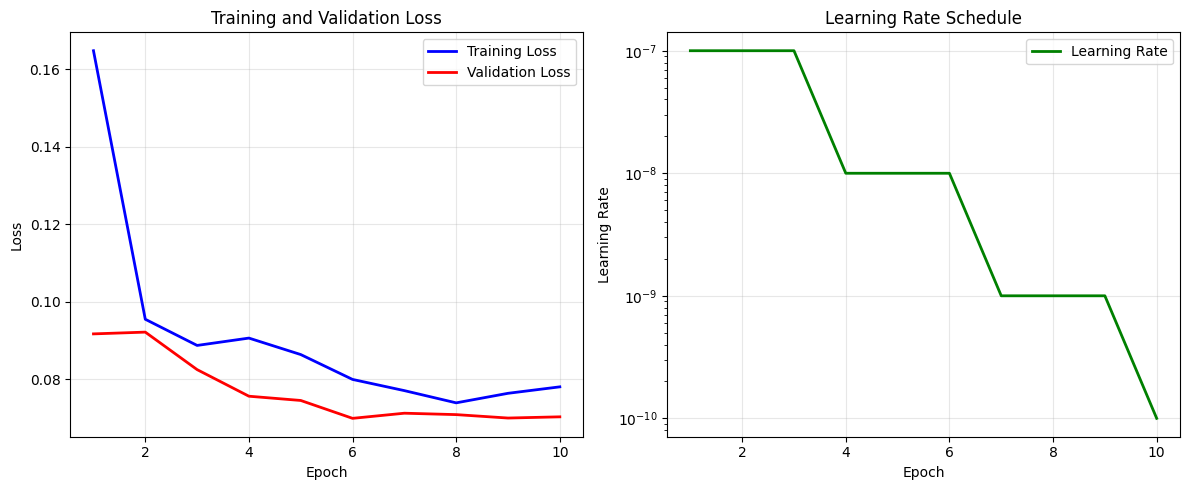

Training plots generated
MODEL EVALUATION

Testing model on validation batch...
Predictions generated for 4 images

Image 1:
Ground truth boxes: 1
Predicted detections: 5
Top predictions:
1. Battery: 0.966[191.645, 302.7, 250.0, 368.7]
2. Knife: 0.113[495.553, 167.5, 559.7, 216.3]
3. Knife: 0.093[448.042, 180.0, 576.3, 213.8]

Image 2:
Ground truth boxes: 1
Predicted detections: 7
Top predictions:
1. Battery: 0.972[180.490, 390.3, 236.2, 450.4]
2. Fireworks: 0.118[373.367, 401.0, 449.7, 527.9]
3. Fireworks: 0.105[384.378, 418.7, 417.1, 510.5]

Image 3:
Ground truth boxes: 1
Predicted detections: 6
Top predictions:
1. Fireworks: 0.938[306.929, 400.9, 450.2, 523.6]
2. Fireworks: 0.470[325.966, 439.2, 434.2, 508.9]
3. Fireworks: 0.329[371.389, 409.8, 417.5, 517.0]

Image 4:
Ground truth boxes: 1
Predicted detections: 11
Top predictions:
1. Battery: 0.317[320.388, 324.7, 382.6, 375.5]
2. Fireworks: 0.177[146.041, 183.6, 281.3, 259.9]
3. Battery: 0.150[557.915, 249.0, 595.7, 313.8]
TRAINING

In [20]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xray_dataset import create_data_loaders
import time
import matplotlib.pyplot as plt

def create_model(num_classes: int) -> FasterRCNN:
    """Create Faster R-CNN model with ResNet-18 backbone."""

    # Model building
    # Load a pre-trained ResNet-18 model
    backbone = torchvision.models.resnet18(pretrained=True)
    # Remove the last two layers (avgpool and fc)
    backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
    # FasterRCNN needs to know the number of output channels in the backbone
    backbone.out_channels = 512

    # Define the anchor generator
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    # Define the RoI pooler
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    # Create the Faster R-CNN model
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    # Replace the classifier with a new one for our number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=num_classes)

    return model

# Model training
# Implement your methods here
class Trainer:
    """Training class for Faster R-CNN model."""

    def __init__(self, model, device, train_loader, val_loader=None):
        self.model = model.to(device)
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader

        # # Optimizer 1 (SGD)
        # self.optimizer = torch.optim.SGD(
        #     self.model.parameters(),
        #     lr=0.005,
        #     momentum=0.9,
        #     weight_decay=0.0005
        # )

        # Optimizer 2 (AdamW)
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=1e-4,
            weight_decay=0.05
        )

        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer,
            step_size=3,
            gamma=0.1
        )

        # Training history
        self.train_losses = []
        self.val_losses = []

        # Statistics for debugging
        self.skipped_batches = 0
        self.filtered_boxes = 0

    def _has_valid_boxes(self, targets):
        """Check if targets contain valid bounding boxes."""
        for target in targets:
            boxes = target['boxes']
            if len(boxes) == 0:
                continue

            # Check for valid box dimensions
            valid_boxes = self._filter_valid_boxes(boxes)
            if len(valid_boxes) > 0:
                return True
        return False
    
    def _filter_valid_boxes(self, boxes, min_size=1.0):
        """Filter out invalid bounding boxes."""
        if len(boxes) == 0:
            return boxes
        
        # Calculate box dimensions
        widths = boxes[:, 2] - boxes[:, 0]   # x2 - x1
        heights = boxes[:, 3] - boxes[:, 1]  # y2 - y1

        # Find valid boxes (non-zero dimensions and minimum size)
        valid_mask = (widths >= min_size) & (heights >= min_size) & \
                     (boxes[:, 0] >= 0) & (boxes[:, 1] >= 0) & \
                     (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])    

        return boxes[valid_mask]            

    def _clean_targets(self, targets):
        """Clean targets by removing invalid bounding boxes."""
        cleaned_targets = []

        for target in targets:
            boxes = target['boxes']
            labels = target['labels']

            # Handle missing or mispelled keys
            image_id = target.get('image_id', torch.tensor(-1))
            # Calculate area if not provided
            if 'area' not in target:
                if len(boxes) > 0:
                    areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
                else:
                    areas = torch.tensor([], dtype=torch.float32)
            else:
                areas = target['area']
            
            # Handle iscrowd with proper default
            iscrowd = target.get('iscrowd', torch.zeros((len(boxes),), dtype=torch.int64))

            if len(boxes) == 0:
                # Keep empty targets as they are
                cleaned_targets.append({
                    'boxes': boxes,
                    'labels': labels,
                    'image_id': image_id,
                    'area': areas,
                    'iscrowd': iscrowd,
                })
                continue

            # Filter valid boxes
            valid_boxes = self._filter_valid_boxes(boxes)
            if len(valid_boxes) == 0:
                # No valid boxes, create empty target
                cleaned_targets.append({
                    'boxes': torch.zeros((0, 4), dtype=boxes.dtype, device=boxes.device),
                    'labels': torch.zeros((0,), dtype=labels.dtype, device=labels.device),
                    'image_id': image_id,
                    'area': torch.zeros((0,), dtype=torch.float32, device=boxes.device),
                    'iscrowd': torch.zeros((0,), dtype=torch.int64, device=boxes.device),
                })
                continue

            # Find indices of valid boxes
            widths = boxes[:, 2] - boxes[:, 0]
            heights = boxes[:, 3] - boxes[:, 1]
            valid_masks = ((widths >= 1.0) & (heights >= 1.0) & 
                          (boxes[:, 0] >= 0) & (boxes[:, 1] >=0) & 
                          (boxes[:, 2] >= boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1]))

            # Filter all target components
            cleaned_target = {
                'boxes': boxes[valid_masks],
                'labels': labels[valid_masks],
                'image_id': target['image_id'],
                'area': boxes[valid_masks] if torch.is_tensor(areas) and len(areas.shape) > 0 else areas,
                'iscrowd': iscrowd[valid_masks] if torch.is_tensor(iscrowd) and len(iscrowd.shape) > 0 else iscrowd,
            }

            # Update filtered boxes count
            original_count = len(boxes)
            filtered_count = len(cleaned_target['boxes'])
            self.filtered_boxes += (original_count - filtered_count)

            cleaned_targets.append(cleaned_target)

        return cleaned_targets

    def train_epoch(self):
        """Train for one epoch."""
        self.model.train()
        epoch_loss = 0
        num_batches = 0
        epoch_skipped = 0

        for batch_idx, (images, targets) in enumerate(self.train_loader):
            if not images:
                continue

            # Clean targets by removing invalid boxes
            targets = self._clean_targets(targets)

            # Check if we have any valid targets after cleaning
            if not self._has_valid_boxes(targets):
                epoch_skipped += 1
                continue

            try:
                images = [image.to(self.device) for image in images]
                targets = [{k: v.to(self.device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

                # Forward pass
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

                # Check for invalid loss
                if not torch.isfinite(losses):
                    print(f"Warning: Invalid loss detected in batch {batch_idx}, skipping...")
                    epoch_skipped += 1
                    continue

                # Backward pass
                self.optimizer.zero_grad()
                losses.backward()

                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                self.optimizer.step()

                epoch_loss += losses.item()
                num_batches += 1

            except Exception as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                epoch_skipped += 1
                continue

        self.skipped_batches += epoch_skipped

        if num_batches == 0:
            print("Warning: No valid batches processed in this epoch!")
            return 0.0
        
        avg_loss = epoch_loss / num_batches

        if epoch_skipped > 0:
            print(f"Skipped {epoch_skipped} batches due to invalid data")

        return avg_loss
    
    def validate(self):
        """Validate the model."""
        if self.val_loader is None:
            return 0
        
        self.model.eval()
        val_loss = 0
        num_batches = 0
        val_skipped = 0

        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(self.val_loader):
                if not images:
                    continue

                # Clean targets
                targets = self._clean_targets(targets)

                # Check if we have invalid targets
                if not self._has_valid_boxes(targets):
                    val_skipped += 1
                    continue

                try:
                    images = [image.to(self.device) for image in images]
                    targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

                    # Set model to training mode for loss calculation
                    self.model.train()
                    loss_dict = self.model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())

                    if torch.isfinite(losses):
                        val_loss += losses.item()
                        num_batches += 1
                    else:
                        val_skipped += 1

                except Exception as e:
                    print(f"Error in validation batch {batch_idx}: {str(e)}")
                    val_skipped += 1
                    continue

            self.model.eval()

            if num_batches == 0:
                return 0.0
            
            if val_skipped > 0:
                print(f"Skipped {val_skipped} validation batches")

            return val_loss / num_batches
        
    def train(self, num_epochs: int, save_path: str = None):
        """Train the model for specified number of epochs."""
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Using device: {self.device}")

        for epoch in range(num_epochs):
            start_time = time.time()

            # Train
            train_loss = self.train_epoch()
            self.train_losses.append(train_loss)

            # Validate
            val_loss = self.validate()
            if val_loss > 0:
                self.val_losses.append(val_loss)

            # Update learning rate
            self.scheduler.step()

            # Print progress
            epoch_time = time.time() - start_time
            current_lr = self.scheduler.get_last_lr()[0]

            print(f"Epoch {epoch+1}/{num_epochs}: "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"LR: {current_lr:.6f}, "
                  f"Time: {epoch_time:.2f}s")
            
            # Save model checkpoint
            if save_path and (epoch + 1) % 5 == 0:
                checkpoint_path = f"{save_path}_epoch_{epoch+1}.pth"
                self.save_model(checkpoint_path)
                print(f"Model saved to {checkpoint_path}")

        # Print final statistics
        print(f"\nTraining completed!")
        print(f"Total skipped batches: {self.skipped_batches}")
        print(f"Total filtered boxes: {self.filtered_boxes}")

        # Save final model
        if save_path:
            final_path = f"{save_path}_final.pth"
            self.save_model(final_path)
            print(f"Final model saved to {final_path}")

    def save_model(self, path: str):
        """Save model state."""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'skipped_batches': self.skipped_batches,
            'filtered_boxes': self.filtered_boxes
        }, path)

    def load_model(self, path: str):
        """Load model state."""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        self.skipped_batches = checkpoint.get('skipped_batches', 0)
        self.filtered_boxes = checkpoint.get('filtered_boxes', 0)

    def plot_losses(self):
        """Plot training and validation losses."""
        plt.figure(figsize=(12, 5))

        # Plot losses
        plt.subplot(1, 2, 1)
        epochs = range(1, len(self.train_losses) + 1)
        plt.plot(epochs, self.train_losses, 'b-', label='Training Loss', linewidth=2)
        if self.val_losses:
            plt.plot(epochs, self.val_losses, 'r-', label='Validation Loss', linewidth=2)
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot learning rate
        plt.subplot(1, 2, 2)
        lrs = [self.optimizer.param_groups[0]['lr'] * (0.1 ** (epoch // 3)) for epoch in range(len(self.train_losses))]
        plt.plot(epochs, lrs, 'g-', label='Learning Rate', linewidth=2)
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.yscale('log')

        plt.tight_layout()
        plt.show()

    def get_training_stats(self):
        """Get training statistics. """
        return {
            'total_epochs': len(self.train_losses),
            'final_train_loss': self.train_losses[-1] if self.train_losses else 0,
            'final_val_loss': self.val_losses[-1] if self.val_losses else 0,
            'skipped_batches': self.skipped_batches,
            'filtered_boxes': self.filtered_boxes,
        }
    
def main():
    """Main training function with comprehensive trainer integration."""
    # Set paths
    IMAGE_DIR = 'dataset/DvXray_Positive_Samples'
    ANNOTATION_DIR = 'dataset/DvXray_Positive_Samples'
    MODEL_SAVE_PATH='faster_rcnn_xray'

    # Training parameters
    BATCH_SIZE = 4
    NUM_EPOCHS = 10
    IMAGE_TYPE = "OL"  # Can be "OL" or "SD"
    RESUME_TRAINING = False # Set to True to resume from checkpoint
    CHECKPOINT_PATH = None # Path to checkpoint if resuming

    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    print("="*60)
    print("SETTING UP DATA LOADERS")
    print("="*60)

    # Create data loaders
    try:
        data_dict = create_data_loaders(
                image_dir=IMAGE_DIR,
                annotation_dir=ANNOTATION_DIR,
                image_type=IMAGE_TYPE,
                batch_size=BATCH_SIZE,
                num_workers=2   # Reduce if you have memory issues
            )
        print("Data loaders created successfully")
    except Exception as e:
        print(f"Error creating data loaders: {e}")
        return None, None, None   # Return None values to avoid unpacking errors

    # Get dataset information
    full_dataset =data_dict['full_dataset']
    label_mapping = full_dataset.get_label_mapping()
    num_classes = len(label_mapping['label_to_id']) + 1  # +1 for background

    print(f"Number of classes: {num_classes}")
    print(f"Labels: {list(label_mapping['label_to_id'].keys())}")
    print(f"Total samples: {len(full_dataset)}")

    # Print data split information
    loaders = data_dict['loaders']
    for split, loader in loaders.items():
        if loader:
            print(f"{split.capitalize()} batches: {len(loader)}")

    print("="*60)
    print("CREATING MODEL")
    print("="*60)

    # Create model
    try:
        print("Creating Faster R-CNN model...")
        model = create_model(num_classes)

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model created successfully")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
    except Exception as e:
        print(f"Error creating model: {e}")
        return None, None, None

    print("="*60)
    print("INITIALIZING TRAINER")
    print("="*60)

    # Create trainer
    try:
        trainer = Trainer(
            model=model,
            device=device,
            train_loader=data_dict['loaders']['train'],
            val_loader=data_dict['loaders'].get('val')
        )
        print("Trainer initialized successfully")
    except Exception as e:
        print(f"Error initializing trainer: {e}")
        return None, None, None 
    
    # Resume training if requested
    if RESUME_TRAINING and CHECKPOINT_PATH:
        print(f"Resuming training from : {CHECKPOINT_PATH}")
        try:
            trainer.load_model(CHECKPOINT_PATH)
            print("Checkpoint loaded successfully")

            # Print load training history
            stats = trainer.get_training_stats()
            print(f"Resumed from epoch {stats['total_epochs']}")
            print(f"Previous best train loss: {stats['final_train_loss']:.4f}")
            if stats['final_val_loss'] > 0:
                print(f"Previous best val loss: {stats['final_val_loss']:.4f}")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Starting fresh training...")

    print("="*60)
    print("START TRAINING")
    print("="*60)

    # Train model
    try:
        print(f"Training for {NUM_EPOCHS} epochs...")
        print(f"Batch size: {BATCH_SIZE}")
        print(f"Image type: {IMAGE_TYPE}")
        print()

        trainer.train(num_epochs=NUM_EPOCHS, save_path=MODEL_SAVE_PATH)
        print("Training completed successfully")
    except Exception as e:
        print(f"Training failed: {e}")
        print("Attempting to save current state...")
        try:
            emergency_path = f"{MODEL_SAVE_PATH}_emergency.pth"
            trainer.save_model(emergency_path)
            print(f"Emergency checkpoint saved to: {emergency_path}")
        except:
            print("Could not save emergency checkpoint")
        return None, None, None

    print("="*60)
    print("TRAINING STATISTICS")
    print("="*60)

    # Get and display training statistics
    stats = trainer.get_training_stats()
    print(f"Total epochs completed: {stats['total_epochs']}")
    print(f"Final training loss: {stats['final_train_loss']:.4f}")
    if stats['final_val_loss'] > 0:
        print(f"Final validation loss: {stats['final_val_loss']:.4f}")
    print(f"Total skipped batches: {stats['skipped_batches']}")
    print(f"Total filtered batches: {stats['filtered_boxes']}")

    # Plot training curves
    print("\nGenerating training plots...")
    try:
        trainer.plot_losses()
        print("Training plots generated")
    except Exception as e:
        print(f"Error generating plots: {e}")

    print("="*60)
    print("MODEL EVALUATION")
    print("="*60)

    # Test the model on validation data
    print("\nTesting model on validation batch...")
    model.eval()

    if 'val' in loaders and loaders['val'] is not None:
        try:
            # Get a batch from validation loader
            val_loader = loaders['val']
            images, targets = next(iter(val_loader))
            
            # Clean targets using trainer's method
            cleaned_targets = trainer._clean_targets(targets)

            # Move to device
            images = [img.to(device) for img in images]

            # Make predictions
            with torch.no_grad():
                predictions = model(images)

            print(f"Predictions generated for {len(predictions)} images")
            
            # Display prediction results
            for i, (pred, target) in enumerate(zip(predictions, cleaned_targets)):
                num_detections = len(pred['boxes'])
                num_gt_boxes = len(target['boxes'])

                print(f"\nImage {i+1}:")
                print(f"Ground truth boxes: {num_gt_boxes}")
                print(f"Predicted detections: {num_detections}")

                if num_detections > 0:
                    # Show top 3 predictions
                    top_scores = pred['scores'][:3].cpu().numpy()
                    top_labels = pred['labels'][:3].cpu().numpy()
                    top_boxes = pred['boxes'][:3].cpu().numpy()

                    print(f"Top predictions:")
                    for j, (score, label, box) in enumerate(zip(top_scores, top_labels, top_boxes)):
                        # Convert label ID back to label name
                        label_name = None
                        for name, id_val in label_mapping['label_to_id'].items():
                            if id_val == label:
                                label_name = name
                                break
                        
                        print(f"{j+1}. {label_name or f'Class_{label}'}: {score:.3f}"
                              f"[{box[0]:.3f}, {box[1]:.1f}, {box[2]:.1f}, {box[3]:.1f}]")
                else:
                    print("No detections above threshold")

        except Exception as e:
            print(f"Error during model evaluation: {e}")

    elif 'test' in loaders and loaders['test'] is not None:
        print("No validation set available, testing on test set...")
        try:
            test_loader = loaders['test']
            images, targets = next(iter(test_loader))

            images = [img.to(device) for img in images]

            with torch.no_grad():
                predictions = model(images)

            print(f"Test predictions generated for {len(predictions)} images")

            for i, pred in enumerate(predictions):
                num_detections = len(pred['boxes'])
                print(f"Test Image {i+1}: {num_detections} detections")

                if num_detections > 0:
                    print(f"Top score: {pred['scores'][0]:.3f}")
        
        except Exception as e:
            print(f"Error during test evaluation: {e}")
    
    else:
        print("No validation or test data available for evaluation")

    print("="*60)
    print("TRAINING SUMMARY")
    print("="*60)

    # Final summary
    final_model_path = f"{MODEL_SAVE_PATH}_final.pth"
    print(f"Model saved to: {final_model_path}")
    print(f"Training completed successfully!")
    print(f"Device used: {device}")
    print(f"Total epochs: {stats['total_epochs']}")
    print(f"Final loss: {stats['final_train_loss']:.4f}")

    if stats['filtered_boxes'] > 0:
        print(f"Note: {stats['filtered_boxes']} invalid bounding boxes were filtered during training")

    if stats['skipped_batches'] > 0:
        print(f"Note: {stats['skipped_batches']} batches were skipped due to invalid data")

    print("\nTraining pipeline completed successfully!")

    return trainer, model, stats

if __name__ == "__main__":
    # Run main function and capture results
    try:
        trainer, model, stats = main()

        if trainer is not None and model is not None and stats is not None:
            # Optional: Additional post-training analysis
            print("\n" + "="*60)
            print("POST-TRAINING OPTIONS")
            print("="*60)
            print("You can now:")
            print("1. Use 'trainer.plot_loss()' to view training curves")
            print("2. Use 'trainer.save_model(path)' to save additional checkpoints")
            print("3. Use 'trainer.eval()' and run inference on new images")
            print("4. Access training statistics with 'trainer.get_training_stats()")
    
    except Exception as e:
        print(f"Main function failed: {e}")
        import traceback
        traceback.print_exc()

## Question 4 (15 Marks, Suggested timing: 20 mins)

Analyze performance of your model on the test set. Calculate precision, recall and F1 score with an iou_threshold of 0.5 and detection confidence threshold of your choice.

STARTING MODEL EVALUATION
Using device: cpu

Step 1: Creating data loaders...
Image directory: dataset/DvXray_Positive_Samples
Annotation directory: dataset/DvXray_Positive_Samples
Image type: OL
Batch size: 4
Found 500 annotation files

Loading P00497.json
Raw data type: <class 'dict'>
Found objects under key: 'objects'
Found 1 objects
Sample object keys: ['label', 'ol_bb', 'sd_bb']
Found path: dataset/DvXray_Positive_Samples/P00497_OL.png
Loaded: P00497

Loading P00436.json
Raw data type: <class 'dict'>
Found objects under key: 'objects'
Found 1 objects
Sample object keys: ['label', 'ol_bb', 'sd_bb']
Found path: dataset/DvXray_Positive_Samples/P00436_OL.png
Loaded: P00436

Loading P00319.json
Raw data type: <class 'dict'>
Found objects under key: 'objects'
Found 1 objects
Sample object keys: ['label', 'ol_bb', 'sd_bb']
Found path: dataset/DvXray_Positive_Samples/P00319_OL.png
Loaded: P00319

Loading P00037.json
Raw data type: <class 'dict'>
Found objects under key: 'objects'
Found 1 

/home/robin/Coding_Assignment/Git/Computer-Vision/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/robin/Coding_Assignment/Git/Computer-Vision/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model created successfully
Loading state dict...
State dict type: <class 'dict'>
State dict keys: ['model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'train_losses', 'val_losses']...
Found model_state_dict key
Loading state dict into model...
Model loaded successfully from faster_rcnn_xray_final.pth
Model loaded successfully

Step 4: Verifying data loaders...
Available loader keys: ['train', 'val', 'test']

Step 5: Creating trainer...
Trainer created successfully

Step 6: Running evaluation...
Starting comprehensive model evaluation...
Evaluating model with:
IoU threshold: 0.5
Confidence threshold: 0.05
Device: cpu


/home/robin/Coding_Assignment/Git/Computer-Vision/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Processing batch 1/19
Processing batch 11/19

Calculating metrics...

MODEL EVALUATION RESULTS
IoU Threshold: 0.5
Confidence Threshold: 0.05
Total Images Evaluated: 75

OVERALL METRICS:
----------------------------------------
Macro Precision: 0.1038
Macro Recall: 0.7286
Macro F1: 0.1754
Micro Precision: 0.1150
Micro Recall: 0.8800
Micro F1: 2.0000

MAP METRICS:
----------------------------------------
mAP@0.5:0.95: 0.0025

PER-CLASS METRICS:
--------------------------------------------------------------------------------
Class           Precision  Recall    , F1         Support   
-----------------------------------------------------------------
Battery         0.2683     0.9706     0.4204     34        
Fireworks       0.1186     0.9333     0.2105     15        
Gun             0.0769     1.0000     0.1429     2         
Knife           0.0554     0.7391     0.1030     23        
Wrench          0.0000     0.0000     0.0000     1         


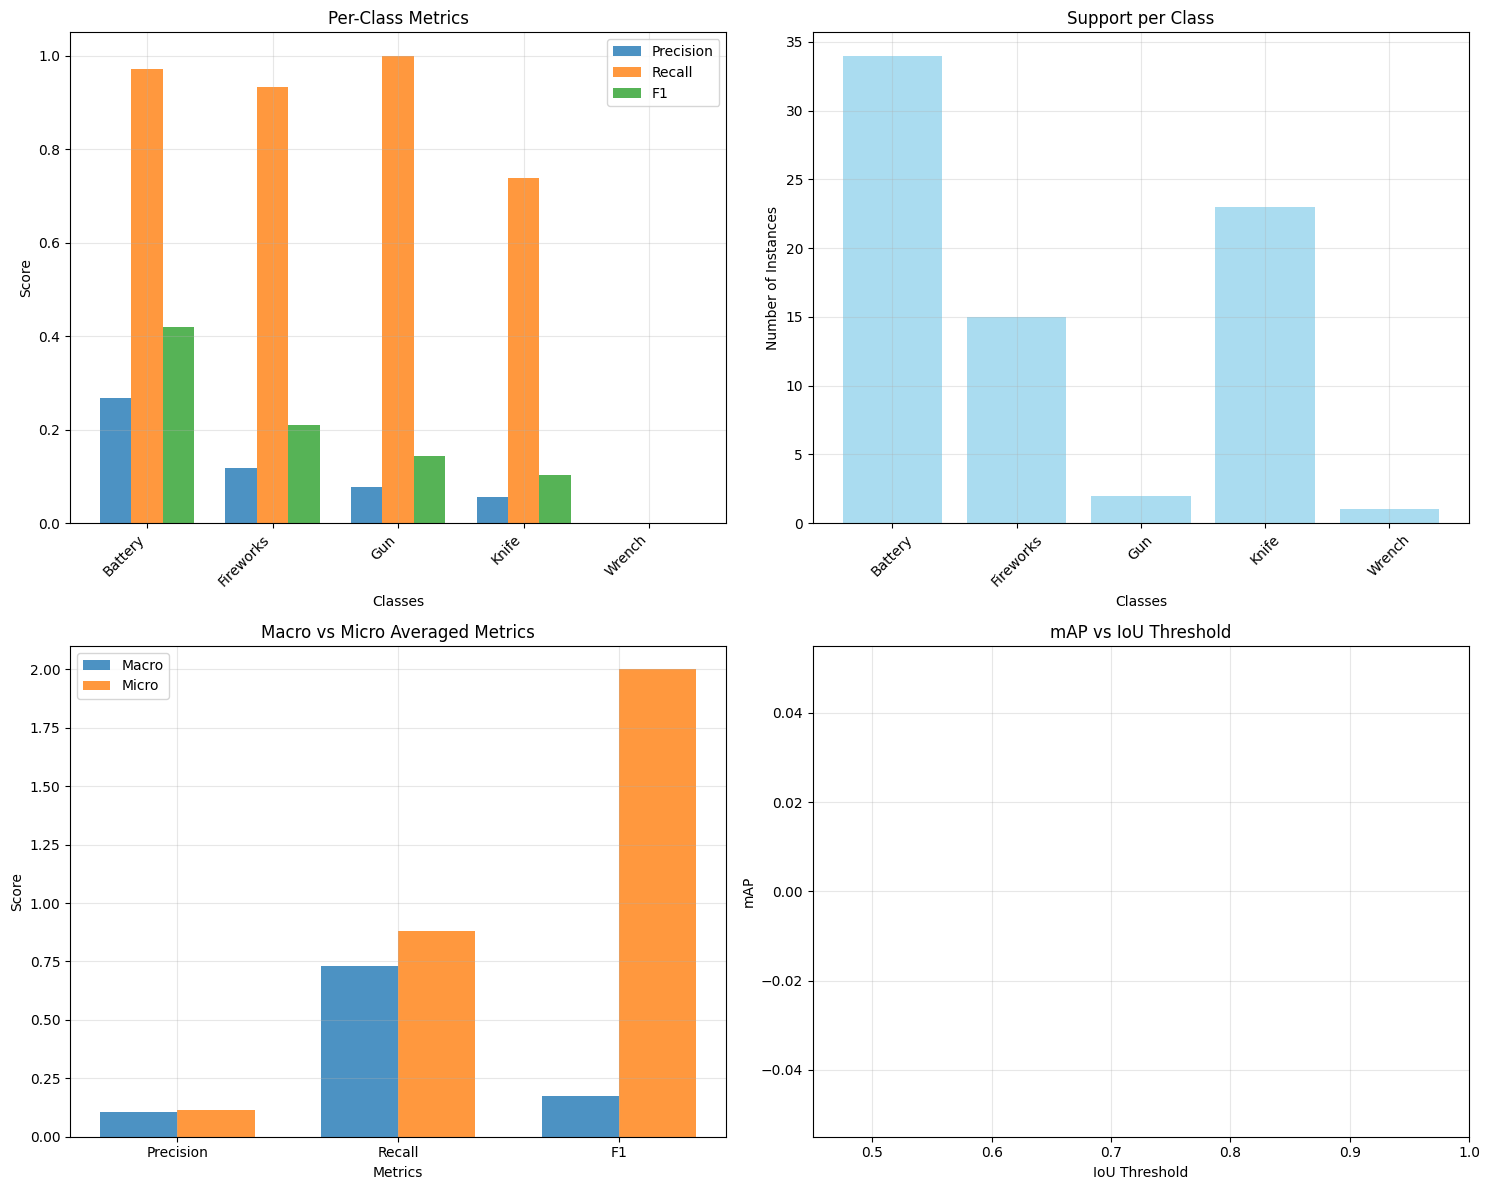

Evaluatiuon completed successfully

Step 7: Testing different confidence thresholds...

Evaluating with confidence threshold: 0.01
Evaluating model with:
IoU threshold: 0.5
Confidence threshold: 0.01
Device: cpu


/home/robin/Coding_Assignment/Git/Computer-Vision/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Processing batch 1/19
Processing batch 11/19

Calculating metrics...

MODEL EVALUATION RESULTS
IoU Threshold: 0.5
Confidence Threshold: 0.01
Total Images Evaluated: 75

OVERALL METRICS:
----------------------------------------
Macro Precision: 0.1038
Macro Recall: 0.7286
Macro F1: 0.1754
Micro Precision: 0.1150
Micro Recall: 0.8800
Micro F1: 2.0000

MAP METRICS:
----------------------------------------
mAP@0.5:0.95: 0.0025

PER-CLASS METRICS:
--------------------------------------------------------------------------------
Class           Precision  Recall    , F1         Support   
-----------------------------------------------------------------
Class_1         0.2683     0.9706     0.4204     34        
Class_2         0.1186     0.9333     0.2105     15        
Class_3         0.0769     1.0000     0.1429     2         
Class_4         0.0554     0.7391     0.1030     23        
Class_7         0.0000     0.0000     0.0000     1         

Evaluating with confidence threshold: 0.001


In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List
from xray_trainer import create_model, Trainer
from xray_dataset import create_data_loaders
import os

class ModelEvaluator:
    """Comprehensive evaluation class for object detection models."""

    def __init__(self, model, device, iou_threshold: float = 0.5, conf_threshold: float = 0.5):
        self.model = model
        self.device = device
        self.iou_threshold = iou_threshold
        self.conf_threshold = conf_threshold
        self.predictions = []
        self.ground_truths = []
        self.class_names = {}

    def calculate_iou(self, box1: torch.Tensor, box2: torch.Tensor) -> float:
        """Calculate IoU between two boxes."""
        # Convert to [x1, y1, x2, y2] format if needed
        if len(box1.shape) == 1:
            box1 = box1.unsqueeze(0)
        if len(box2.shape) == 1:
            box2 = box2.unsqueeze(0)

        # Calculate intersection coordinates
        x1_inter = torch.max(box1[:, 0], box2[:, 0])
        y1_inter = torch.max(box1[:, 1], box2[:, 1])
        x2_inter = torch.min(box1[:, 2], box2[:, 2])
        y2_inter = torch.min(box1[:, 3], box2[:, 3])

        # Calculate intersection area
        inter_width = torch.clamp(x2_inter - x1_inter, min=0)
        inter_height = torch.clamp(y2_inter - y1_inter, min=0)
        intersection = inter_width * inter_height

        # Calculate union area
        area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
        area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
        union = area1 + area2 - intersection

        # Calculate IoU
        iou = intersection / (union + 1e-8)
        return iou

    def evaluate_batch(self, images: List[torch.Tensor], targets: List[Dict]) -> None:
        """Evaluate a batch of images and store results."""
        self.model.eval()

        with torch.no_grad():
            # Move images to device
            images = [img.to(self.device) for img in images]

            # Get predictions
            predictions = self.model(images)

            # Process each image
            for pred, target in zip(predictions, targets):
                # Filter predictions by confidence threshold
                conf_mask = pred['scores'] >= self.conf_threshold
                filtered_pred = {
                    'boxes': pred['boxes'][conf_mask],
                    'labels': pred['labels'][conf_mask],
                    'scores': pred['scores'][conf_mask],
                } 

                self.predictions.append(filtered_pred)
                self.ground_truths.append(target)

    def calculate_metrics_per_class(self) -> Dict:
        """Calculate precision, recall, F1 for each class."""
        # Collect all unique classes
        all_classes = set()
        for gt in self.ground_truths:
            all_classes.update(gt['labels'].cpu().numpy())
        for pred in self.predictions:
            if len(pred['labels']) > 0:
                all_classes.update(pred['labels'].cpu().numpy())

        metrics = {}

        for class_id in all_classes:
            if class_id == 0:   # Skip background class
                continue

            tp = 0  # True positives
            fp = 0  # False positives
            fn = 0  # False negatives

            for pred, gt in zip(self.predictions, self.ground_truths):
                # Get predictions and ground truths for this class
                pred_mask = pred['labels'] == class_id
                gt_mask = gt['labels'] == class_id

                pred_boxes = pred['boxes'][pred_mask]
                gt_boxes = gt['boxes'][gt_mask]

                # Track which ground truth boxes have been matched
                gt_matched = [False] * len(gt_boxes)

                # For each predicted box, find best matching ground truth
                for pred_box in pred_boxes:
                    best_iou = 0
                    best_gt_idx = -1

                    for gt_idx, gt_box in enumerate(gt_boxes):
                        if gt_matched[gt_idx]:
                            continue

                        iou = self.calculate_iou(pred_box, gt_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx

                    # Check if match is good enough
                    if best_iou >= self.iou_threshold:
                        tp += 1
                        gt_matched[best_gt_idx] = True
                    else:
                        fp += 1

                # Count unmatched groud truth boxes as false negatives
                fn += sum(1 for matched in gt_matched if not matched)

            # Calculate metrics
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            metrics[class_id] = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'tp': tp,
                'fp': fp,
                'fn': fn,
                'support': tp + fn  # Total ground truth instances
            } 

        return metrics
    
    def calculate_overall_metrics(self, metrics: Dict) -> Dict:
        """Calculate macro and micro averaged metrics."""
        if not metrics:
            return {'macro_precision': 0, 'macro_recall': 0, 'macro_f1': 0,
                    'micro_precision': 0, 'micro_recall': 0, 'micro_f1': 0}

        # Macro averages (simple average across classes)
        macro_precision = np.mean([m['precision'] for m in metrics.values()])
        macro_recall = np.mean([m['recall'] for m in metrics.values()])
        macro_f1 = np.mean([m['f1'] for m in metrics.values()])

        # Micro averages (weighted by support)
        total_tp = sum(m['tp'] for m in metrics.values())
        total_fp = sum(m['fp'] for m in metrics.values())
        total_fn = sum(m['fn'] for m in metrics.values())

        micro_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
        micro_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
        micro_f1 = 2 * micro_precision * micro_recall / (micro_precision * micro_recall) if (micro_precision * micro_recall) > 0 else 0

        return {
            'macro_precision': macro_precision,
            'macro_recall': macro_recall,
            'macro_f1': macro_f1,
            'micro_precision': micro_precision,
            'micro_recall': micro_recall,
            'micro_f1': micro_f1
        }

    def calculate_map(self, iou_thresholds: List[float] = None) -> Dict:
        """Calculate mean Average Precision (mAP)."""
        if iou_thresholds is None:
            iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95] 

        # Collect all unique classes
        all_classes = set()
        for gt in self.ground_truths:
            all_classes.update(gt['labels'].cpu().numpy())
        all_classes.discard(0)  # Remove background

        aps = {}
        for iou_thresh in iou_thresholds:
            class_aps = []

            for class_id in all_classes:
                # Collect all predictions and groundtruths for this class
                all_pred_boxes = []
                all_pred_scores = []
                all_gt_boxes = []

                for pred, gt in zip(self.predictions, self.ground_truths):
                    pred_mask = pred['labels'] == class_id
                    gt_mask = gt['labels'] == class_id

                    if pred_mask.any():
                        all_pred_boxes.extend(pred['boxes'][pred_mask].cpu().numpy())
                        all_pred_scores.extend(pred['scores'][pred_mask].cpu().numpy())

                    if gt_mask.any():
                        all_gt_boxes.extend(gt['boxes'][gt_mask].cpu().numpy())

                if not all_pred_boxes or not all_gt_boxes:
                    continue

                # Sort predictions by confidence
                sorted_indices = np.argsort(all_pred_scores)[::-1]
                sorted_pred_boxes = [all_pred_boxes[i] for i in sorted_indices]
                sorted_scores = [all_pred_scores[i] for i in sorted_indices]

                # Calculate precision-recall curve
                tp = np.zeros(len(sorted_pred_boxes))
                fp = np.zeros(len(sorted_pred_boxes))

                for i, pred_box in enumerate(sorted_pred_boxes):
                    best_iou = 0
                    for gt_box in all_gt_boxes:
                        iou = self.calculate_iou(
                            torch.tensor(pred_box).unsqueeze(0),
                            torch.tensor(gt_box).unsqueeze(0)
                        )[0]
                        best_iou = max(best_iou, iou)

                    if best_iou >= iou_thresh:
                        tp[i] = 1
                    else:
                        fp[i] = 1

                # Calculate cumulative precision and recall
                tp_cumsum = np.cumsum(tp)
                fp_cumsum = np.cumsum(fp)

                recalls = tp_cumsum / len(all_gt_boxes)
                precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)

                # Calculate AP using interpolation
                ap = self._calculate_ap(recalls, precisions)
                class_aps.append(ap)

            aps[f'mAP@0.5:0.95'] = np.mean(class_aps) if class_aps else 0

        # Calculate mAP@0.5:0.95 (COCO style)
        aps['mAP@0.5:0.95'] = np.mean(list(aps.values()))

        return aps

    def _calculate_ap(self, recalls: np.ndarray, precisions: np.ndarray) -> float:
        """Calculate Average Precision using 11-point interpolation."""
        ap = 0
        for threshold in np.arange(0, 1.1, 0.1):
            if np.sum(recalls >= threshold) == 0:
                p = 0
            else:
                p = np.max(precisions[recalls >= threshold])
            ap += p / 11
        return ap
    
    def evaluate_model(self, data_loader, class_names: Dict[int, str] = None) -> Dict:
        """Evaluate model on entire dataset."""
        self.class_names = class_names or {}
        self.predictions = []
        self.ground_truths = []

        print(f"Evaluating model with:")
        print(f"IoU threshold: {self.iou_threshold}")
        print(f"Confidence threshold: {self.conf_threshold}")
        print(f"Device: {self.device}")

        # Process all batches
        total_batches = len(data_loader)
        for batch_idx, (images, targets) in enumerate(data_loader):
            if batch_idx % 10 == 0:
                print(f"Processing batch {batch_idx + 1}/{total_batches}")

            self.evaluate_batch(images, targets)

        # Calculate metrics
        print("\nCalculating metrics...")
        class_metrics = self.calculate_metrics_per_class()
        overall_metrics = self.calculate_overall_metrics(class_metrics)
        map_metrics = self.calculate_map()

        return {
            'class_metrics': class_metrics,
            'overall_metrics': overall_metrics,
            'map_metrics': map_metrics,
            'evaluation_params': {
                'iou_threshold': self.iou_threshold,
                'conf_threshold': self.conf_threshold,
                'total_images': len(self.predictions)
            }
        }
    
    def print_results(self, results: Dict) -> None:
        """Print evaluation results in a formatted way."""
        print("\n" + "="*80)
        print("MODEL EVALUATION RESULTS")
        print("="*80)

        # Print evaluation parameters
        params = results['evaluation_params']
        print(f"IoU Threshold: {params['iou_threshold']}")
        print(f"Confidence Threshold: {params['conf_threshold']}")
        print(f"Total Images Evaluated: {params['total_images']}")

        # Print overall metrics
        print("\nOVERALL METRICS:")
        print("-" * 40)
        overall = results['overall_metrics']
        print(f"Macro Precision: {overall['macro_precision']:.4f}")
        print(f"Macro Recall: {overall['macro_recall']:.4f}")
        print(f"Macro F1: {overall['macro_f1']:.4f}")
        print(f"Micro Precision: {overall['micro_precision']:.4f}")
        print(f"Micro Recall: {overall['micro_recall']:.4f}")
        print(f"Micro F1: {overall['micro_f1']:.4f}")

        # Print mAP metrics
        print("\nMAP METRICS:")
        print("-" * 40)
        map_metrics = results['map_metrics']
        for metric_name, value in map_metrics.items():
            print(f"{metric_name}: {value:.4f}")

        # Print per-class metrics
        print("\nPER-CLASS METRICS:")
        print("-" * 80)
        class_metrics = results['class_metrics']

        if class_metrics:
            # Create a formatted table
            print(f"{'Class':<15} {'Precision':<10} {'Recall':<10}, {'F1':<10} {'Support':<10}")
            print("-" * 65) 

            for class_id, metrics in class_metrics.items():
                class_name = self.class_names.get(class_id, f"Class_{class_id}")
                print(f"{class_name:<15} {metrics['precision']:<10.4f} "
                      f"{metrics['recall']:<10.4f} {metrics['f1']:<10.4f} "
                      f"{metrics['support']:<10}")
        else:
            print("No class-specific metrics available")
    
        print("="*80)

    def plot_results(self, results: Dict) -> None:
        """Create visualization plots for evaluation results."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Plot 1: Per-class metrics
        class_metrics = results['class_metrics']
        if class_metrics:
            classes = list(class_metrics.keys())
            class_names = [self.class_names.get(c, f"Class_{c}") for c in classes]

            precisions = [class_metrics[c]['precision'] for c in classes]
            recalls = [class_metrics[c]['recall'] for c in classes]
            f1_scores = [class_metrics[c]['f1'] for c in classes]

            x = np.arange(len(classes))
            width = 0.25

            axes[0, 0].bar(x - width, precisions, width, label='Precision', alpha=0.8)
            axes[0, 0].bar(x, recalls, width, label='Recall', alpha=0.8)
            axes[0, 0].bar(x + width, f1_scores, width, label='F1', alpha=0.8)

            axes[0, 0].set_xlabel('Classes')
            axes[0, 0].set_ylabel('Score')
            axes[0, 0].set_title('Per-Class Metrics')
            axes[0, 0].set_xticks(x)
            axes[0, 0].set_xticklabels(class_names, rotation=45, ha='right')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Support (number of instances) per class
        if class_metrics:
            supports = [class_metrics[c]['support'] for c in classes]
            axes[0, 1].bar(class_names, supports, alpha=0.7, color='skyblue')
            axes[0, 1].set_xlabel('Classes')
            axes[0, 1].set_ylabel('Number of Instances')
            axes[0, 1].set_title('Support per Class')
            axes[0, 1].tick_params(axis='x', rotation=45)
            axes[0, 1].grid(True, alpha=0.3)

        # Plot 3: Overall metrics comparison
        overall = results['overall_metrics']
        metrics_names = ['Precision', 'Recall', 'F1']
        macro_values = [overall['macro_precision'], overall['macro_recall'], overall['macro_f1']]
        micro_values = [overall['micro_precision'], overall['micro_recall'], overall['micro_f1']]

        x = np.arange(len(metrics_names))
        width = 0.35

        axes[1, 0].bar(x - width/2, macro_values, width, label='Macro', alpha=0.8)
        axes[1, 0].bar(x + width/2, micro_values, width, label='Micro', alpha=0.8)
        axes[1, 0].set_xlabel('Metrics')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].set_title('Macro vs Micro Averaged Metrics')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_title('Macro vs Micro Averaged Metrics')
        axes[1, 0].set_xticklabels(metrics_names)
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Plot 4: mAP at different IoU thresholds
        map_metrics = results['map_metrics']
        iou_thresholds = [float(k.split('@')[1]) for k in map_metrics.keys() if '@' in k and ':' not in k]
        map_values = [map_metrics[f'mAP@{iou:.2f}'] for iou in iou_thresholds]

        axes[1, 1].plot(iou_thresholds, map_values, 'o-', linewidth=2, markersize=8)
        axes[1, 1].set_xlabel('IoU Threshold')
        axes[1, 1].set_ylabel('mAP')
        axes[1, 1].set_title('mAP vs IoU Threshold')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].set_xlim(0.45, 1.0)

        plt.tight_layout()
        plt.show()

def load_model_safely(model_path, num_classes, device):
    """Safely load a model with proper error handling."""
    print(f"Attempting to load model from: {model_path}")
    print(f"Number of classes: {num_classes}")
    print(f"Device: {device}")

    try:
        # Check if model file exists
        if not os.path.exists(model_path):
            print(f"Warning: Model file {model_path} does not exist!")
            print("Creating a fresh model instead...")
            model = create_model(num_classes)
            if model is None:
                raise Exception("create_model returned None")
            model.to(device)
            return model

        # Create model first
        print("Creating model architecture...")
        model = create_model(num_classes)
        if model is None:
            raise Exception("create_model returned None")
        print("Model created successfully")

        # Load state dict
        print("Loading state dict...")
        if device.type == 'cuda':
            state_dict = torch.load(model_path, map_location=device)
        else:
            state_dict = torch.load(model_path, map_location='cpu')

        print(f"State dict type: {type(state_dict)}")
        if isinstance(state_dict, dict):
            print(f"State dict keys: {list(state_dict.keys())[:5]}...") # First 5 keys

        # Handle different saving formats
        if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
            print("Found model_state_dict key")
            model_state_dict = state_dict['model_state_dict']
        elif isinstance(state_dict, dict) and 'state_dict' in state_dict:
            print("Found state_dict key")
            model_state_dict = state_dict['state_dict']
        else:
            print("Using direct state dict")
            model_state_dict = state_dict

        # Load the state dict
        print("Loading state dict into model...")
        model.load_state_dict(model_state_dict)
        model.to(device)

        print(f"Model loaded successfully from {model_path}")
        return model

    except Exception as e:
        print(f"Error loading model: {e}")
        print("Attempting to create a fresh model...")

        try:
            # Return a fresh model if loading fails
            model = create_model(num_classes)
            if model is None:
                raise Exception("create_model returned None")
            model.to(device)
            print("Fresh model created successfully")
            return model
        except Exception as e2:
            print(f"Error creating fresh model: {e2}")
            raise Exception(f"Both model loading and creation failed: {e}, {e2}")

def evaluate_trained_model(trainer, model, test_loader, label_mapping,
                            iou_threshold=0.5, conf_threshold=0.5):
    """Evaluate a trained model using the comprehensive evaluation framework."""

    print("Starting comprehensive model evaluation...")

    # Create evaluator
    evaluator = ModelEvaluator(
        model=model,
        device=trainer.device,
        iou_threshold=iou_threshold,
        conf_threshold=conf_threshold
    )

    # Create class names mapping (reverse of label_to_id)
    class_names = {v: k for k, v in label_mapping['label_to_id'].items()}

    # Evaluate model
    results = evaluator.evaluate_model(test_loader, class_names)

    # Print results
    evaluator.print_results(results)

    # Plot results
    evaluator.plot_results(results)

    return results, evaluator

# Example usage function
def run_evaluation_example():
    """Example of how to use the evaluation framework with your trained model.
        This assumes you have already trained a model using the provided training script.
    """

    print("="*60)
    print("STARTING MODEL EVALUATION")
    print("="*60)

    # Set paths
    IMAGE_DIR = 'dataset/DvXray_Positive_Samples'
    ANNOTATION_DIR = 'dataset/DvXray_Positive_Samples'
    MODEL_SAVE_PATH='faster_rcnn_xray_final.pth'

    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Training parameters
    BATCH_SIZE = 4
    IMAGE_TYPE = "OL"  # Can be "OL" or "SD"

    # Step 1: Create data loaders with detailed error handling
    print("\nStep 1: Creating data loaders...")
    try:
        print(f"Image directory: {IMAGE_DIR}")
        print(f"Annotation directory: {ANNOTATION_DIR}")
        print(f"Image type: {IMAGE_TYPE}")
        print(f"Batch size: {BATCH_SIZE}")

        data_dict = create_data_loaders(
                image_dir=IMAGE_DIR,
                annotation_dir=ANNOTATION_DIR,
                image_type=IMAGE_TYPE,
                batch_size=BATCH_SIZE,
                num_workers=2   # Reduce if you have memory issues
            )
        
        if data_dict is None:
            raise Exception("create_data_loaders returned None")

        print("Data loaders created successfully")
        print(f"Data dict keys: {list(data_dict.keys())}")

        # Check if required keys exist
        required_keys = ['full_dataset', 'loaders']
        for key in required_keys:
            if key not in data_dict:
                raise Exception(f"Missing required key '{key}' in data_dict")

    except Exception as e:
        print(f"Error creating data loaders: {e}")
        print("This is likely due to:")
        print("1. Incorrect image/annotation directory paths")
        print("2. Missing or corrupted dataset files")
        print("3. Issues with the create_data_loaders function")
        return None, None, None   

    # Step 2: Get dataset information
    print("\nStep 2: Getting dataset information...")
    try: 
        full_dataset = data_dict['full_dataset']
        if full_dataset is None:
            raise Exception("full_dataset is None")
        
        label_mapping = full_dataset.get_label_mapping()
        if label_mapping is None:
            raise Exception("label mapping is None")
        
        print(f"Label mapping: {label_mapping}")

        num_classes = len(label_mapping['label_to_id']) + 1  # +1 for background
        print(f"Number of classes (including background): {num_classes}")

    except Exception as e:
        print(f"Error getting dataset information: {e}")
        return None, None, None

    # Step 3: Load model
    print("\nStep 3: Loading model...")
    try:
        model = load_model_safely(MODEL_SAVE_PATH, num_classes, device)
        if model is None:
            raise Exception("load model safely returned None")
        print("Model loaded successfully")
    
    except Exception as e:
        print(f"Error in model loading: {e}")
        return None, None, None

    # Create data loaders and verify
    print("\nStep 4: Verifying data loaders...") 
    try:
        if 'loaders' not in data_dict:
            raise Exception("'loaders' key not found in data_dict")

        loaders = data_dict['loaders']
        if loaders is None:
            raise Exception("loaders is None")
    
        print(f"Available loader keys: {list(loaders.keys())}")

        if 'test' not in loaders:
            print("Warning: 'test' loader not found. Available loaders:", list(loaders.keys()))
            # Try to use validation loader if test doesn't exist
            if 'val' in loaders:
                print("Using validation loader instead of test loader")
                test_loader = loaders['val']
            elif 'train' in loaders:
                print("Using train loader for evaluation (not ideal but will work)")
                test_loader = loaders['train']
            else:
                raise Exception("No suitable data loader found")
        
    except Exception as e:
        print(f"Error verifying data loaders: {e}")
        return None, None, None

    # Step 5: Create trainer
    print("\nStep 5: Creating trainer...")
    try:
        # Check if train loader exists
        train_loader = loaders.get('train')
        val_loader = loaders.get('val')

        if train_loader is None:
            print("Warning: train_loader is None, creating minimal trainer")
            # Create a minimal trainer for evaluation only
            class MinimalTrainer:
                def __init__(self, model, device):
                    self.model = model
                    self.device = device

            trainer = MinimalTrainer(model, device)
        else:
            trainer = Trainer(
                model=model,
                device=device,
                train_loader=train_loader,
                val_loader=val_loader
            )
        
        print("Trainer created successfully")

    except Exception as e:
        print(f"Error creating trainer: {e}")
        return None, None, None

    # Step 6: Run evaluation
    print("\nStep 6: Running evaluation...")
    try:
        test_loader = loaders.get('test')
        results, evaluator = evaluate_trained_model(
            trainer=trainer,
            model=model,
            test_loader=test_loader,
            label_mapping=label_mapping,
            iou_threshold=0.5,
            conf_threshold=0.05
        )

        print("Evaluatiuon completed successfully")

    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

    # Step 7: Try different confidence thresholds
    print("\nStep 7: Testing different confidence thresholds...")
    try:    
        for conf_thresh in [0.01, 0.001]:
            print(f"\nEvaluating with confidence threshold: {conf_thresh}")
            evaluator.conf_threshold = conf_thresh
            results = evaluator.evaluate_model(test_loader)
            evaluator.print_results(results)
    except Exception as e:
        print(f"Error testing different thresholds: {e}")
        # Continue anyway since main evaluation worked

    return results, evaluator, model


if __name__ == "__main__":
    run_evaluation_example()

## Question 5 (20 Marks, Suggested timing: 40 mins)

Write a function to calculate the Frechet distance between the dataset you are using and a given image with the Resnet-18 backbone you trained, similar to how FID is calculated. Calculate the distance for the three images specified below. Also answer the following questions.

1. Do you think it's a good idea to replace inception-v3, which is the default feature extractor used to calculate FID, with the Resnet-18 you have just trained?
2. What are the better alternatives than this Resnet-18 as feature extractor for X-ray synthetic data evaluation?
3. What are possible ways to test different metrics on how well they evaluate the difference between synthetic data and real data?

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from scipy import linalg
from PIL import Image
import torchvision.transforms as transforms
from torchvision import models
import os
from xray_dataset import XrayDataset
from xray_evaluator import load_model_safely
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# ------------------------------
# Feature Extraction Function
# ------------------------------
def extract_features(feature_extractor, dataloader, device):
    feature_extractor.eval()
    features = []

    with torch.no_grad():
        for batch in dataloader:
            if batch is None:
                continue

            images, _ = batch    # images shape: (B, C, H, W)
            batch_features = []

            if len(images) == 0:
                print("Warning: Empty image batch")
                continue

            for image in images:
                if not isinstance(image, torch.Tensor):
                    print("Non-tensor image:", type(image))
                    continue

                image = image.unsqueeze(0).to(device)   # Add batch dimension and move to device
                feat = feature_extractor(image)         # Output shape: (1, D)

                if torch.isnan(feat).any() or torch.isinf(feat).any():
                    print("Warning: Feature vector has NaN or Inf")
                    continue

                feat = feat.view(-1).cpu().numpy()      # Flatten and move to CPU numpy
                batch_features.append(feat)

            features.extend(batch_features)

    return np.concatenate([f[np.newaxis, :] for f in features], axis=0)   # shape: (N, D)

# ------------------------------
# Check for invalid values
# ------------------------------
def has_invalid_values(arr):
    return np.isnan(arr).any() or np.isinf(arr).any()

# ------------------------------
# Frechet Distance Calculation
# ------------------------------
def calculate_frechet_distance(real_features, generated_features):
    # make sure your inputs are numpy ndarrays with shape (n, d) and (m, d), where d is the size of the features extracted
    if len(real_features.shape) != 2 or len(generated_features.shape) != 2:
        raise ValueError("Features must be 2D arrays")
    
    if real_features.shape[1] != generated_features.shape[1]:
        raise ValueError("Feature dimensions must match")
    
    # Check for invalid values
    if has_invalid_values(real_features):
        print("real_features contains NaNs or Infs!")
        return float('inf')
    if has_invalid_values(generated_features):
        print("generated_features contains NaNs or Infs!")
        return float('inf')

    # Calculate means and covriance
    mu1 = real_features.mean(axis=0)
    mu2 = generated_features.mean(axis=0)

    # For single generated sample, use zero covariance
    if generated_features.shape[0] == 1:
        sigma1 = np.cov(real_features, rowvar=False)
        sigma2 = np.zeros_like(sigma1)
    else:
        sigma1 = np.cov(real_features, rowvar=False)
        sigma2 = np.cov(generated_features, rowvar=False)

    # Ensure covariance matrices are 2D
    if sigma1.ndim == 0:
        sigma1 = np.array([[sigma1]])
    if sigma2.ndim == 0:
        sigma2 = np.array([[sigma2]])

    # Check for numerical issues
    if not np.all(np.isfinite(mu1)) or not np.all(np.isfinite(mu2)):
        print("Mean contains NaN or Inf")
        return float('inf')
    
    if not np.all(np.isfinite(mu1)) or not np.all(np.isfinite(sigma2)):
        print("Covariance contains NaN or Inf")
        return float('inf')
    
    diff = mu1 - mu2

    # Add small regularization to diagonal for numerical stability
    eps = 1e-6
    sigma1_reg = sigma1 + eps * np.eye(sigma1.shape[0])
    sigma2_reg = sigma2 + eps * np.eye(sigma2.shape[0])

    try:
        # Compute matrix square root
        covmean, _ = linalg.sqrtm(sigma1_reg.dot(sigma2_reg), disp=False)

        if not np.all(np.isfinite(covmean)):
            print("sqrtm produced NaNs or Infs")
            return float('inf')

        if np.iscomplexobj(covmean):
            if np.allclose(covmean.imag, 0, atol=1e-6):
                covmean = covmean.real
            else:
                print("Complex values in sqrm result")
                return float('inf')

        frechet_distance = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)

        if not np.isfinite(frechet_distance):
            print("Final Frechet distance is not finite")
            return float('inf')

        return frechet_distance
    
    except Exception as e:
        print(f"Error in Frechet distance calculation: {e}")
        return float('inf')

# ------------------------------
# Single Image Distance
# ------------------------------
def frechet_distance_with_image(image_path, transform, real_features, feature_extractor, device):
    try:
        if isinstance(image_path, str):
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Image file not found: {image_path}")
            image = Image.open(image_path).convert('RGB')  # Loads image from the file path
        else:
            image = image_path # Fallback if already PIL

        image = transform(image).unsqueeze(0).to(device)    # Shape: (1, C, H, W)

        with torch.no_grad():
            # Implement inference and feature dimension processing here.
            features = feature_extractor(image)             # Shape: (1, D)
            print(f"Extracted feature shape: {features.shape}")
            print(f"Feature vector stats - min: {features.min().item():.6f}, max: {features.max().item():.6F}")

            generated_features = features.cpu().numpy()     # Convert to numpy

            if has_invalid_values(generated_features):
                print("Generated features contain NaNs or Infs")
                return float('inf')

        return calculate_frechet_distance(real_features, generated_features)
    
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return float('inf')

# ------------------------------------------------
# Feature Extractor (ResNet-18 Penultimate Layer)
# ------------------------------------------------
def get_feature_extractor(resnet_model):
    modules = list(resnet_model.children())[:-1]    # Remove the final FC
    backbone = nn.Sequential(*modules)
    return nn.Sequential(backbone, nn.Flatten())

# ------------------------------------------------
# Collate Function
# ------------------------------------------------
def collate_fn(batch):
    # Filter out None samples
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    
    # Separate images and labels
    images, labels = zip(*batch)

    # Stack images
    images = torch.stack(images, 0)

    return images, labels

# ------------------------------------------------
# Main
# ------------------------------------------------
def main():
    # Get device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load your trained Faster R-CNN model
    try:
        # Replace with the actual path of your saved model
        MODEL_SAVE_PATH='faster_rcnn_xray_final.pth'

        # Load the checkpoint
        checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device)

        # Debug: Print what's in the checkpoint
        print(f"Checkpoint type: {type(checkpoint)}")
        if isinstance(checkpoint, dict):
            print(f"Checkpoint keys: {list(checkpoint.keys())}")
        
        # Extract the model from the checkpoint dictionary
        if isinstance(checkpoint, dict):
            # For Faster R-CNN, try to use the load_model_safely function first
            try:
                num_classes = 8
                custom_model = load_model_safely(MODEL_SAVE_PATH, num_classes, device)
                print("Successfully loaded model using load_model_safely")
            except Exception as load_safe_error:
                print(f"load_model_safely failed: {load_safe_error}")

                # Fallback: Try to extract common keys
                possible_model_keys = ['model', 'model_state_dict', 'state_dict', 'net', 'net']

                custom_model = None
                for key in possible_model_keys:
                    if key in checkpoint:
                        if key == 'model':
                            # Direct model object
                            custom_model = checkpoint[key]
                            print(f"Found model under key: '{key}")
                            break
                        elif 'model_state_dict' in key:
                            # State dictionary - need Faster R-CNN architecture
                            print(f"Found state dict under key: {key}")
                            
                            # Create Faster R-CNN architecture
                            custom_model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
                            try:
                                custom_model.load_state_dict(checkpoint[key])
                                print("Successfully loaded state_dict into Faster R-CNN architecture")
                            except Exception as load_error:
                                print(f"Failed to load state_dict into Faster R-CNN: {load_error}")
                                raise load_error
                            break

            if custom_model is None:
                # If no standard keys found, print all keys for debugging
                print("Could not find model in standard keys. Available keys:")
                for key, value in checkpoint.items():
                    print(f"{key}: {type(value)}")
                raise ValueError("Could not extract model from checkpoint")
            
        else:
            # If it's not a dict, it should be the model directly
            custom_model = checkpoint

        custom_model.to(device)
        custom_model.eval() # Set to evaluation mode
        print(f"Successfully loaded trained model from {MODEL_SAVE_PATH}")

    except Exception as e:
        print(f"Error loading trained model: {e}")
        print("Falling back to pretrained ResNet-18...")
        custom_model = models.resnet18(pretrained=True)
        custom_model.to(device)

    # Extract features using your trained model
    # Note: Faster R-CNN has a different architecture than ResNet18
    try:
        if hasattr(custom_model, 'backbone'):
            # For Faster R-CNN, extract features from the backbone
            feature_extractor = custom_model.backbone
            # Add global average pooling and flattening
            feature_extractor = nn.Sequential(
                feature_extractor,
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Flatten()
            ).to(device)

        else:
            # For ResNet18 or other models, use the original method
            feature_extractor = get_feature_extractor(custom_model).to(device)
    
        feature_extractor.eval()
        print("Feature extractor created successfully")

    except Exception as e:
        print(f"Error creating feature extractor: {e}")
        print("Using standard ResNet18 feature extractor...")
        feature_extractor = get_feature_extractor(custom_model).to(device)
        feature_extractor.eval()

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    
    # Prepare your dataset and dataloader
    image_dir='dataset/DvXray_Positive_Samples'
    annotation_dir='dataset/DvXray_Positive_Samples'

    try:
        dataset = XrayDataset(image_dir, annotation_dir, transform=transform)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

        print("Extracting features from real dataset...")
        # Extract real dataset features
        real_features = extract_features(feature_extractor, dataloader, device)
        print(f"Extracted {real_features[0]} real features with dimension {real_features.shape[1]}")

        # Print some statistics about real features
        print(f"Real features - min: {real_features.min():.6f}, max: {real_features.max():.6f}")
        print(f"Real features - mean: {real_features.mean():.6f}, std: {real_features.std():.6f}")

        # Calculate Frechet distance for the three images
        image_paths = [
            'dataset/DvXray_Positive_Samples/P00001_OL.png',
            'natural_image_sample.jpeg',
            'xray_image_sample.jpeg'
        ]

        for i, image_path in enumerate(image_paths, start=1):
            if not os.path.exists(image_path):
                print(f"Image {image_path} not found.")
                continue

            print(f"\nProcessing image {i}: {os.path.basename(image_path)}")
            distance = frechet_distance_with_image(
                image_path, transform, real_features, feature_extractor, device
            )
            print(f"Frechet Distance for image {i} ({os.path.basename(image_path)}): {distance:.4f}")

    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()


"""
1. Do you think it's a good idea to replace inception-v3, which is the default feature extractor used to calculate FID, with the Resnet-18 you have just trained?
Yes, if the goal is domain-specific evaluation (e.g. X-ray). 
The default Inception-v3 used in FID is trained on natural images (ImageNet). 
It is not optimal for extracting meaningful features from X-ray images, since their texture, contrast, and semantics differ significantly
from natural scenes.

2. What are the better alternatives than this Resnet-18 as feature extractor for X-ray synthetic data evaluation?
Some better alternatives are 
a. ResNet-50/ResNet-101 
b. DenseNet121 
c. EfficientNet-B0~B4
d. Vision Transformer(ViT)
e. CheXNet (DenseNet121 pre-trained on ChestX-ray14)
f. UNet encoders 

3. What are possible ways to test different metrics on how well they evaluate the difference between synthetic data and real data?
a. Perform correlation with human judgements (i.e., expert rating) by collecting expert annotations (i.e., radiologists or domain practitioners),
ask them to score image realism, pathology correctness or usefulness, and compare metric values (e.g., FID, PRD, KID, C2ST) with expert 
scores using Spearman or Pearson correlation.
b. Perform correlation with downstream task performance by training a model using only (i) real data and (ii) real and synthetic data, evaluate
downstream metrics (e.g., mAP, AUC) and compare how each synthetic data set's metric (FID, PRD, etc) correlates with the downstream task
performance.
c. Perform classifier two-sample test (C2ST) by training a binary classifier to distinguish real vs synthetic data, use AUC/accuracy as proxy 
and repeat for each generation method.
d. Perform ablation and sensitivity analysis by creating multiple synthetic datasets varying noise level, artifact strength, image sharpness and
structural distortions, apply your metric to all variants and plot metric score vs degree of distortion.
e. Check consistency across feature extractors by repeating FID, KID and PRD using Inception-v3, ResNet-50, CheXnet and your trained ResNet-18
and see how stable the metric rankings are across backbones.  
"""

Using device: cpu
Checkpoint type: <class 'dict'>
Checkpoint keys: ['model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'train_losses', 'val_losses', 'skipped_batches', 'filtered_boxes']
Attempting to load model from: faster_rcnn_xray_final.pth
Number of classes: 8
Device: cpu
Creating model architecture...


/home/robin/Coding_Assignment/Git/Computer-Vision/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/robin/Coding_Assignment/Git/Computer-Vision/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model created successfully
Loading state dict...
State dict type: <class 'dict'>
State dict keys: ['model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'train_losses', 'val_losses']...
Found model_state_dict key
Loading state dict into model...
Model loaded successfully from faster_rcnn_xray_final.pth
Successfully loaded model using load_model_safely
Successfully loaded trained model from faster_rcnn_xray_final.pth
Feature extractor created successfully
Extracting features from real dataset...
Extracted [6.57472946e-03 2.22734526e-01 2.98428327e-01 1.90591979e+00
 1.59993267e+00 4.57929587e-03 2.83323824e-01 1.19175136e+00
 7.13920593e-01 1.59660864e+00 7.05254376e-01 2.91571051e-01
 1.21436119e+00 7.13261843e-01 5.60941756e-01 2.04026148e-01
 6.97100878e-01 1.44156992e+00 5.60186803e-01 0.00000000e+00
 1.28692591e+00 1.23346925e+00 3.22638720e-01 7.76443958e-01
 3.29467878e-02 1.15872696e-01 6.79759562e-01 6.64216518e-01
 2.08297515e+00 2.18981123e+00 4.08935636e-01 1.5

"\n1. Do you think it's a good idea to replace inception-v3, which is the default feature extractor used to calculate FID, with the Resnet-18 you have just trained?\nYes, if the goal is domain-specific evaluation (e.g. X-ray). \nThe default Inception-v3 used in FID is trained on natural images (ImageNet). \nIt is not optimal for extracting meaningful features from X-ray images, since their texture, contrast, and semantics differ significantly\nfrom natural scenes.\n\n2. What are the better alternatives than this Resnet-18 as feature extractor for X-ray synthetic data evaluation?\nSome better alternatives are \na. ResNet-50/ResNet-101 \nb. DenseNet121 \nc. EfficientNet-B0~B4\nd. Vision Transformer(ViT)\ne. CheXNet (DenseNet121 pre-trained on ChestX-ray14)\nf. UNet encoders \n\n3. What are possible ways to test different metrics on how well they evaluate the difference between synthetic data and real data?\na. Perform correlation with human judgements (i.e., expert rating) by collecting 

That's the end of this interview task. Please save this notebook and send back to us. Thanks for your efforts!